In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from shutil import copyfileobj
from torchvision import datasets, transforms, models

In [2]:
PATH_TO_FOLDS = "data/train_val_txt_files_per_fold"
PATH_TO_DATA = "data/"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "aligned/"

In [3]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split() 
            label = int(label)
            #if 'gender' in self.txt_file:
            #    label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }
    
class AdienceDatasetCombined(Dataset):
    
    def __init__(self, txt_dir, subset, root_dir, transform):
        self.txt_dir = txt_dir
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        data2 = []
        age_txt_file = f'{self.txt_dir}/age_{self.subset}.txt'
        gender_txt_file = f'{self.txt_dir}/gender_{self.subset}.txt'
        age_file = open(age_txt_file)        
        for line in age_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            data.append((image_file, label))
        age_file.close()
        gender_file = open(gender_txt_file)
        for line in gender_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            for record in data:
                if (record[0] == image_file):
                    data2.append((image_file, record[1] + 10*label))
                    break
        return data2
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

In [4]:
transforms_list = [
    transforms.Resize(256), # 0 (required)
    transforms.CenterCrop(227), #1 (required)
    transforms.RandomHorizontalFlip(), #2
    transforms.ToTensor(), #3 (required)
    transforms.RandomCrop(227) #4
]

# Adversarial training
# Look into increase or decrease contrast
# Look into principal component analysis (PCA) on the RGB colourspace

# Pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# Essentially, meaning getting parameters but not calculating accuracy

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

In [5]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender", or 'both'
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    root_dir = PATH_TO_IMAGE_FOLDERS
    if c == "both":
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}'
        transformed_dataset = AdienceDatasetCombined(txt_file, s, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader
    else:
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'        
        transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader    

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
PATH_TO_MODELS = "models_pretrained"

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    def freeze_layer(layer):
        for param in layer.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

class NewNet(nn.Module):
    
    def __init__(self):
        super(NewNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)    
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

def freeze_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
def unfreeze_layer(layer):
    for param in layer.parameters():
        param.requires_grad = True

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [10]:
criterion = nn.NLLLoss()

In [11]:
minibatch_size = 50
num_epochs = 200
lr = 0.0001  # initial learning rate

In [12]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency=50, val_dataloader=None, 
          patience=None, tuning_threshold = True):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    best_iteration = 1
    best_validation_loss = np.inf
    tune_flip = False
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                if patience == None:
                    training_loss.append(running_loss/checkpoint_frequency)
                    validation_loss.append(validate(net, val_dataloader))
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    save_network(net, f'{filename}_checkpoint{checkpoint}')                        
                elif patience > 0:
                    training_loss_result = running_loss/checkpoint_frequency
                    validation_loss_result = validate(net, val_dataloader)
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    if best_validation_loss >= validation_loss_result:
                        print(f'Best loss improvement from {best_validation_loss} to {validation_loss_result} in epoch {epoch+1}')
                        best_validation_loss = validation_loss_result
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                        save_network(net, f'{filename}_checkpoint{checkpoint}')
                        best_iteration = iteration + 1
                    elif best_iteration + patience * checkpoint_frequency <= iteration:
                        if (tune_flip == False and tuning_threshold == True):
                            training_loss.append(training_loss_result)
                            validation_loss.append(validation_loss_result)
                            tune_flip = True
                            unfreeze_layer(net.conv1)
                            unfreeze_layer(net.pool1)

                            unfreeze_layer(net.conv2)
                            unfreeze_layer(net.pool2)

                            unfreeze_layer(net.conv3)
                            unfreeze_layer(net.pool3)
                            optimizer = optim.Adam(net.parameters(), lr / 10)
                            patience += 20
                            print(f"Patience ran out at {iteration}. Finetuning, and improving patience.")
                        else:
                            print(f"Patience ran out at {iteration}. Ending training")
                            return net, training_loss, validation_loss
                    else:
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                checkpoint += 1
                running_loss = 0
            iteration += 1

    return net, training_loss, validation_loss

In [13]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [14]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

In [15]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c != 'gender':
        result['one_off_match'] = 0
    if c == 'both':
        result['gender_match'] = 0
        result['age_match'] = 0
        result['one_off_age_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c != 'gender':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()
            if c == 'both':
                for count, o in enumerate(outputs):
                    if o <= 7: # male
                        if labels[count] >= 0 and labels[count] <= 7:
                            result['gender_match'] += 1
                        if labels[count] == o or labels[count] == o + 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count] == o + 1 or labels[count] == o - 1 \
                        or labels[count] == o + 8 or labels[count] == o + 6:
                            result['one_off_age_match'] += 1
                    elif o >= 10: # female
                        if labels[count] >= 10 and labels[count] <= 17:
                            result['gender_match'] += 1
                        if labels[count] == o or labels[count] == o - 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count] == o + 1 or labels[count] == o - 1 \
                        or labels[count] == o - 8 or labels[count] == o - 6:
                            result['one_off_age_match'] += 1

    return result           

In [16]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

In [17]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50, patience=10):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            Net().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            NewNet().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [18]:
def pretrain_save(net, c, fold, train_transform_index, checkpoint_frequency=50, patience=None, 
                  tuning_threshold=True):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.to(device)
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            net,
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience,
            tuning_threshold = tuning_threshold 
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            net,
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience,
            tuning_threshold = tuning_threshold 
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [19]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

In [20]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

In [21]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age", "gender" or "both".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

In [22]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [23]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    if c != "both":
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        if c != 'gender':
            return {
                'accuracy': performance['exact_match']/performance['total'],
                'one-off accuracy': performance['one_off_match']/performance['total']
            }
        else:
            return {
                'accuracy': performance['exact_match']/performance['total']
            }
    else:
        net = NewNet().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'gender accuracy': performance['gender_match']/performance['total'],
            'age accuracy': performance['age_match']/performance['total'],
            'one-off age accuracy': performance['one_off_age_match']/performance['total']
        }

In [24]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [25]:
import pandas as pd

df = pd.read_csv("data_faces/list_attr_celeba.csv")
df = df[['image_id', 'Male']]

In [26]:
!rm -rf data_celaba_split
!mkdir data_celeba_split && mkdir data_celeba_split/Male && mkdir data_celeba_split/Female

mkdir: cannot create directory ‘data_celeba_split’: File exists


In [27]:
num = 8000
s0 = 0
s1 = 0

for i, (_, i_row) in enumerate(df.iterrows()):
    if s0 < num:
        if i_row['Male'] == 1:
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data_celeba_split/Male/' + i_row['image_id'])
  
    if s1 < num:
        if i_row['Male'] == -1:
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data_celeba_split/Female/' + i_row['image_id'])
  
    if s0 == num and s1 == num:
        break

In [26]:
img_list = os.listdir('data_celeba_split/Male/')
img_list.extend(os.listdir('data_celeba_split/Female/'))

In [27]:
transform=transforms.Compose([transforms.Resize((227,227)), 
                    transforms.RandomHorizontalFlip(p=0.7),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])])

In [28]:
batch_size = 128
celeba_data = datasets.ImageFolder('data_celeba_split', transform=transform)

In [29]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [32]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True, num_workers=24)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=24)

In [33]:
model = NewNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

In [34]:
epochs = 100
train_loss = []
acc=[]
for epoch in range(epochs):
   
    total_train_loss = 0
    accuracy = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

 
    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)


    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for idx, (image, label) in enumerate(testLoader):
            image, label = image.to(device), label.to(device)

            ## Forward Pass
            scores = model(image)

            _,predictions=torch.max(scores.data,1)
            num_correct += (predictions == label).sum().int()
            num_samples += predictions.size(0)
        accuracy=float(num_correct) / float(num_samples) * 100
        acc.append(accuracy)
        print(f"Epoch: {epoch} | Train Loss: {total_train_loss} | accuracy : {accuracy}")

KeyboardInterrupt: 

In [ ]:
PATH="models/model_celeba_original_network.pt"
torch.save(model.state_dict(),PATH)

In [ ]:
testiter = iter(testLoader)
images, labels = testiter.next()

with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')

In [32]:
PATH="models/model_celeba_original_network.pt"

model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)
#freeze_layer(model.fc1)

#freeze_layer(model.fc2)



print(model)

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


minibatch:49, epoch:1, iteration:49, training_error:3.6634385776519776, validation_error:3.268483877182007
Best loss improvement from inf to 3.268483877182007 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.056958317756653, validation_error:2.9911133448282876
Best loss improvement from 3.268483877182007 to 2.9911133448282876 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.9071748638153077, validation_error:2.9016969998677573
Best loss improvement from 2.9911133448282876 to 2.9016969998677573 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.834483985900879, validation_error:2.8447408278783164
Best loss improvement from 2.9016969998677573 to 2.8447408278783164 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.78624614238739, validation_error:2.7844301760196686
Best loss improvement from 2.8447408278783164 to 2.7844301760196686 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.738095078468323, validation

minibatch:35, epoch:12, iteration:2499, training_error:1.8128147959709167, validation_error:1.9884230742851894
Best loss improvement from 1.9991422146558762 to 1.9884230742851894 in epoch 12
minibatch:85, epoch:12, iteration:2549, training_error:1.8348137354850769, validation_error:1.976190487543742
Best loss improvement from 1.9884230742851894 to 1.976190487543742 in epoch 12
minibatch:135, epoch:12, iteration:2599, training_error:1.804066071510315, validation_error:1.976365755001704
minibatch:185, epoch:12, iteration:2649, training_error:1.807994134426117, validation_error:1.9707258890072505
Best loss improvement from 1.976190487543742 to 1.9707258890072505 in epoch 12
minibatch:11, epoch:13, iteration:2699, training_error:1.7507640504837036, validation_error:1.9415894200404484
Best loss improvement from 1.9707258890072505 to 1.9415894200404484 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:1.754118721485138, validation_error:1.9724636177221935
minibatch:111, epoc

minibatch:73, epoch:25, iteration:5449, training_error:0.9386776971817017, validation_error:1.72044175863266
Patience ran out at 5449. Finetuning, and improving patience.
minibatch:123, epoch:25, iteration:5499, training_error:0.8978276145458222, validation_error:1.7259226987759273
minibatch:173, epoch:25, iteration:5549, training_error:0.9261290574073792, validation_error:1.7149786204099655
minibatch:223, epoch:25, iteration:5599, training_error:0.8922665894031525, validation_error:1.7109814633925755
minibatch:49, epoch:26, iteration:5649, training_error:0.8703914546966552, validation_error:1.7307530045509338
minibatch:99, epoch:26, iteration:5699, training_error:0.8680031895637512, validation_error:1.705856740474701
minibatch:149, epoch:26, iteration:5749, training_error:0.8636781370639801, validation_error:1.7095335374275844
minibatch:199, epoch:26, iteration:5799, training_error:0.7915111565589905, validation_error:1.725914458433787
minibatch:25, epoch:27, iteration:5849, training_

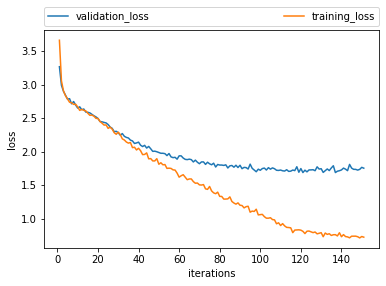

[3.268483877182007,
 2.9911133448282876,
 2.9016969998677573,
 2.8447408278783164,
 2.7844301760196686,
 2.7909696300824485,
 2.7143890062967935,
 2.748451352119446,
 2.6965715189774833,
 2.65112112959226,
 2.6699907779693604,
 2.6275892555713654,
 2.637111395597458,
 2.5912384688854218,
 2.5879952907562256,
 2.578713119029999,
 2.5580861667792,
 2.5363702476024628,
 2.5192387302716575,
 2.495971292257309,
 2.4508701463540397,
 2.445667952299118,
 2.436582386493683,
 2.4292350510756173,
 2.40525754292806,
 2.367767035961151,
 2.348814755678177,
 2.2986700435479483,
 2.304170995950699,
 2.283829261859258,
 2.245442564288775,
 2.2705157697200775,
 2.2296207000811896,
 2.2130767107009888,
 2.2044755021731057,
 2.1726741045713425,
 2.160598486661911,
 2.1226221372683844,
 2.1306153337160745,
 2.1423233250776925,
 2.0968172202507653,
 2.0770031809806824,
 2.0948206037282944,
 2.0541465332110724,
 2.078674857815107,
 2.0432427475849786,
 2.0047575185696282,
 2.0077284375826516,
 1.9991422146

In [58]:
# Last layer was replaced by a clean layer

pretrain_save(model, 'both', 0, 0, patience=10)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:49, epoch:1, iteration:49, training_error:3.5077372407913208, validation_error:3.253340756451642
Best loss improvement from inf to 3.253340756451642 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.9677429485321043, validation_error:2.9631538302810103
Best loss improvement from 3.253340756451642 to 2.9631538302810103 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.906088557243347, validation_error:2.8904654803099454
Best loss improvement from 2.9631538302810103 to 2.8904654803099454 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8316964721679687, validation_error:2.8287128695735224
Best loss improvement from 2.8904654803099454 to 2.8287128695735224 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.773544602394104, validation_error:2.7606930644423873
Best loss improvement from 2.8287128695735224 to 2.7606930644423873 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.7104905462265014, validat

minibatch:159, epoch:11, iteration:2549, training_error:1.7641771125793457, validation_error:1.9538553776564422
Best loss improvement from 1.9854943222469754 to 1.9538553776564422 in epoch 11
minibatch:209, epoch:11, iteration:2599, training_error:1.7501975107192993, validation_error:1.9786690650162873
minibatch:20, epoch:12, iteration:2649, training_error:1.7506710052490235, validation_error:1.9147764488502785
Best loss improvement from 1.9538553776564422 to 1.9147764488502785 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.6905866837501526, validation_error:1.951001277676335
minibatch:120, epoch:12, iteration:2749, training_error:1.701408975124359, validation_error:1.9151151268570512
minibatch:170, epoch:12, iteration:2799, training_error:1.7301270508766173, validation_error:1.9496509234110515
minibatch:220, epoch:12, iteration:2849, training_error:1.6747184705734253, validation_error:1.9194260438283284
minibatch:31, epoch:13, iteration:2899, training_error:1.661

minibatch:102, epoch:24, iteration:5599, training_error:0.9001207256317139, validation_error:1.651200502007096
minibatch:152, epoch:24, iteration:5649, training_error:0.9009015476703643, validation_error:1.7172967195510864
minibatch:202, epoch:24, iteration:5699, training_error:0.9234156680107116, validation_error:1.698658333884345
minibatch:13, epoch:25, iteration:5749, training_error:0.8868714940547943, validation_error:1.6996149707723547
minibatch:63, epoch:25, iteration:5799, training_error:0.8777361917495727, validation_error:1.6931576949578744
minibatch:113, epoch:25, iteration:5849, training_error:0.8441126847267151, validation_error:1.7440481230064675
minibatch:163, epoch:25, iteration:5899, training_error:0.8632623064517975, validation_error:1.6779879243285567
minibatch:213, epoch:25, iteration:5949, training_error:0.8479544270038605, validation_error:1.6817787046785708
minibatch:24, epoch:26, iteration:5999, training_error:0.8399706184864044, validation_error:1.76591711574130

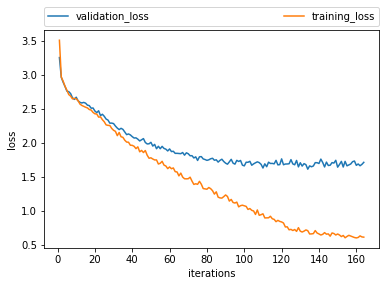

[3.253340756451642,
 2.9631538302810103,
 2.8904654803099454,
 2.8287128695735224,
 2.7606930644423873,
 2.752500957912869,
 2.7243967056274414,
 2.6620723847989685,
 2.6393196759400546,
 2.671362179296988,
 2.617883284886678,
 2.595978992956656,
 2.5868345631493463,
 2.5948957867092557,
 2.5845245961789733,
 2.5550740913108543,
 2.5479253309744374,
 2.509723990051835,
 2.5130562870590776,
 2.468732145097521,
 2.4451215267181396,
 2.4724375671810574,
 2.401190086647316,
 2.420940231393885,
 2.3915220896402993,
 2.35072742568122,
 2.3359513812594943,
 2.290161097491229,
 2.2913840920836837,
 2.2840823155862315,
 2.2477358049816556,
 2.217882650869864,
 2.196086287498474,
 2.2147005001703897,
 2.1992469716955116,
 2.1609032772205494,
 2.1220210040057146,
 2.131927914089627,
 2.117776769178885,
 2.092366483476427,
 2.0722571125736944,
 2.074618449917546,
 2.0552444060643515,
 2.029178813651756,
 2.0462465551164417,
 2.0636246425134166,
 2.0067816663671425,
 1.9854943222469754,
 1.98741506

In [33]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 1, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.5863134336471556, validation_error:3.1676008701324463
Best loss improvement from inf to 3.1676008701324463 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.035923662185669, validation_error:2.915973990051835
Best loss improvement from 3.1676008701324463 to 2.915973990051835 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8608373403549194, validation_error:2.816571006068477
Best loss improvement from 2.915973990051835 to 2.816571006068477 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.800815920829773, validation_error:2.8010598023732505
Best loss improvement from 2.816571006068477 to 2.8010598023732505 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.7430849504470824, validation_error:2.7039990336806685
Best loss improvement from 2.8010598023732505 to 2.7039990336806685 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.721288757324219, validation_

minibatch:129, epoch:11, iteration:2499, training_error:1.8205956029891968, validation_error:1.9865261139693084
minibatch:179, epoch:11, iteration:2549, training_error:1.8162584519386291, validation_error:2.0062932040956287
minibatch:229, epoch:11, iteration:2599, training_error:1.8216570615768433, validation_error:1.9871817827224731
minibatch:42, epoch:12, iteration:2649, training_error:1.7753423142433167, validation_error:1.9426470597585042
Best loss improvement from 1.9808274772432115 to 1.9426470597585042 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.7849338221549989, validation_error:1.9655976957745023
minibatch:142, epoch:12, iteration:2749, training_error:1.7624953532218932, validation_error:1.9619141596334952
minibatch:192, epoch:12, iteration:2799, training_error:1.721357946395874, validation_error:1.9696617700435497
minibatch:5, epoch:13, iteration:2849, training_error:1.7119229197502137, validation_error:1.956970669605114
minibatch:55, epoch:13, iterat

minibatch:148, epoch:24, iteration:5599, training_error:0.9365123140811921, validation_error:1.6933993101119995
Best loss improvement from 1.7083620186205264 to 1.6933993101119995 in epoch 24
minibatch:198, epoch:24, iteration:5649, training_error:0.9653854215145111, validation_error:1.7235270120479442
minibatch:11, epoch:25, iteration:5699, training_error:0.9626335060596466, validation_error:1.765428763848764
minibatch:61, epoch:25, iteration:5749, training_error:0.9378531384468078, validation_error:1.7127955004020974
minibatch:111, epoch:25, iteration:5799, training_error:0.9678947401046752, validation_error:1.7169330340844613
minibatch:161, epoch:25, iteration:5849, training_error:0.9335006666183472, validation_error:1.7834529832557395
minibatch:211, epoch:25, iteration:5899, training_error:0.8997592329978943, validation_error:1.7456003030141194
minibatch:24, epoch:26, iteration:5949, training_error:0.9044793200492859, validation_error:1.7592965408607766
minibatch:74, epoch:26, iter

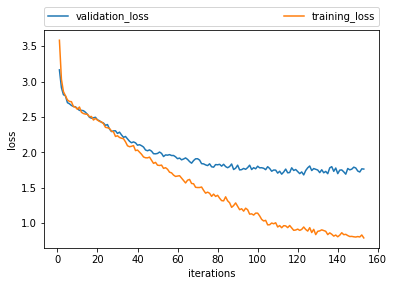

[3.1676008701324463,
 2.915973990051835,
 2.816571006068477,
 2.8010598023732505,
 2.7039990336806685,
 2.6882056483515986,
 2.66494298864294,
 2.6500221181798866,
 2.6456526208806923,
 2.6196379838166415,
 2.594477344442297,
 2.5955997661308006,
 2.5903515109309443,
 2.5685584986651384,
 2.5378955470191107,
 2.497862489135177,
 2.483958500402945,
 2.4899368197829634,
 2.4972014162275524,
 2.4614215426974826,
 2.4485016222353333,
 2.426364439505118,
 2.416345207779496,
 2.3834599035757558,
 2.3946550952063665,
 2.332685850284718,
 2.2956818827876337,
 2.305136901360971,
 2.306818856133355,
 2.269060426288181,
 2.2876091533237033,
 2.2483688946123475,
 2.2137808005015054,
 2.2261449495951333,
 2.1923381443376893,
 2.1585956282085843,
 2.1374378778316356,
 2.149341622988383,
 2.1363102992375693,
 2.102948948189064,
 2.1101318951006287,
 2.096075896863584,
 2.076986074447632,
 2.034924352610553,
 2.024358555122658,
 2.036652891724198,
 2.0188192614802607,
 1.9825595528991133,
 1.980827477

In [34]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.611140375137329, validation_error:3.2144636224817345
Best loss improvement from inf to 3.2144636224817345 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.094073257446289, validation_error:2.936277486659862
Best loss improvement from 3.2144636224817345 to 2.936277486659862 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8767267227172852, validation_error:2.837123994474058
Best loss improvement from 2.936277486659862 to 2.837123994474058 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8559481573104857, validation_error:2.7761829605808965
Best loss improvement from 2.837123994474058 to 2.7761829605808965 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.8122994995117185, validation_error:2.764866996694494
Best loss improvement from 2.7761829605808965 to 2.764866996694494 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.735338215827942, validation_err

minibatch:89, epoch:11, iteration:2499, training_error:1.8644048643112183, validation_error:1.9780573447545369
Best loss improvement from 2.0090622151339494 to 1.9780573447545369 in epoch 11
minibatch:139, epoch:11, iteration:2549, training_error:1.8375000643730164, validation_error:1.9877393952122442
minibatch:189, epoch:11, iteration:2599, training_error:1.8393801856040954, validation_error:1.965655459298028
Best loss improvement from 1.9780573447545369 to 1.965655459298028 in epoch 11
minibatch:239, epoch:11, iteration:2649, training_error:1.8215595531463622, validation_error:1.946335412837841
Best loss improvement from 1.965655459298028 to 1.946335412837841 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.7927280688285827, validation_error:1.9420907276648063
Best loss improvement from 1.946335412837841 to 1.9420907276648063 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.752589588165283, validation_error:1.9646974051440205
minibatch:148, epo

minibatch:47, epoch:23, iteration:5349, training_error:1.0040049350261688, validation_error:1.7474647848694413
minibatch:97, epoch:23, iteration:5399, training_error:1.0655565309524535, validation_error:1.753653362945274
minibatch:147, epoch:23, iteration:5449, training_error:1.037680708169937, validation_error:1.7219383672431663
minibatch:197, epoch:23, iteration:5499, training_error:1.022683789730072, validation_error:1.7670654588275485
minibatch:6, epoch:24, iteration:5549, training_error:1.0290971744060515, validation_error:1.7131179173787434
Best loss improvement from 1.7211398901762787 to 1.7131179173787434 in epoch 24
minibatch:56, epoch:24, iteration:5599, training_error:1.0150720250606537, validation_error:1.726592571647079
minibatch:106, epoch:24, iteration:5649, training_error:0.9872721004486084, validation_error:1.7456684642367892
minibatch:156, epoch:24, iteration:5699, training_error:0.9554180324077606, validation_error:1.7402955955929227
minibatch:206, epoch:24, iteratio

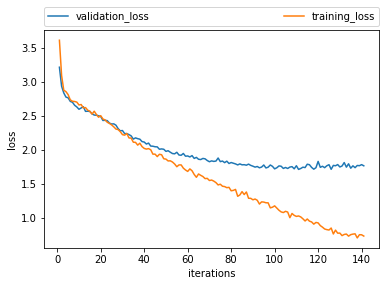

[3.2144636224817345,
 2.936277486659862,
 2.837123994474058,
 2.7761829605808965,
 2.764866996694494,
 2.712673469826027,
 2.6994801803871438,
 2.6556005124692565,
 2.6308879587385388,
 2.596663510357892,
 2.616130987803141,
 2.634377364759092,
 2.566121295646385,
 2.567968589288217,
 2.5647815510078713,
 2.5307759179009333,
 2.5118901906190096,
 2.5091215946056225,
 2.5016016518628157,
 2.490276327839604,
 2.432290041888202,
 2.434741426397253,
 2.429681336438214,
 2.3938408251161927,
 2.379989412095812,
 2.382556915283203,
 2.362923825228656,
 2.312301838839496,
 2.2798681126700506,
 2.28442531603354,
 2.2389660588017217,
 2.2398913789678505,
 2.2248457537757025,
 2.2057837645212808,
 2.15848238379867,
 2.176470469545435,
 2.1648782050168074,
 2.1572023276929504,
 2.1218962227856673,
 2.115200303218983,
 2.0861396348034895,
 2.0998256780483104,
 2.056204160054525,
 2.0537646611531577,
 2.0459589384220265,
 2.0442629478595875,
 2.009187866140295,
 2.014279422936616,
 2.009062215133949

In [35]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.597289762496948, validation_error:3.145490426283616
Best loss improvement from inf to 3.145490426283616 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0432293033599853, validation_error:2.9253711058543277
Best loss improvement from 3.145490426283616 to 2.9253711058543277 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.9234404230117796, validation_error:2.8403212565642137
Best loss improvement from 2.9253711058543277 to 2.8403212565642137 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.819433641433716, validation_error:2.8172881603240967
Best loss improvement from 2.8403212565642137 to 2.8172881603240967 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.7880195951461793, validation_error:2.7264872239186215
Best loss improvement from 2.8172881603240967 to 2.7264872239186215 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.767197890281677, validati

minibatch:129, epoch:11, iteration:2449, training_error:1.7544779348373414, validation_error:1.9562380038774931
Best loss improvement from 1.9643835471226618 to 1.9562380038774931 in epoch 11
minibatch:179, epoch:11, iteration:2499, training_error:1.764335391521454, validation_error:1.9173983473044176
Best loss improvement from 1.9562380038774931 to 1.9173983473044176 in epoch 11
minibatch:229, epoch:11, iteration:2549, training_error:1.7972776174545289, validation_error:1.898002422772921
Best loss improvement from 1.9173983473044176 to 1.898002422772921 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.7151178073883058, validation_error:1.9081072578063378
minibatch:97, epoch:12, iteration:2649, training_error:1.7123369073867798, validation_error:1.8907648279116704
Best loss improvement from 1.898002422772921 to 1.8907648279116704 in epoch 12
minibatch:147, epoch:12, iteration:2699, training_error:1.6943939733505249, validation_error:1.8478288329564607
Best loss impr

minibatch:145, epoch:23, iteration:5249, training_error:0.9607241892814636, validation_error:1.6082320763514593
minibatch:195, epoch:23, iteration:5299, training_error:0.962044529914856, validation_error:1.586337570960705
minibatch:13, epoch:24, iteration:5349, training_error:0.9486202144622803, validation_error:1.5792034222529485
Best loss improvement from 1.5838454915927007 to 1.5792034222529485 in epoch 24
minibatch:63, epoch:24, iteration:5399, training_error:0.9485563492774963, validation_error:1.5975039188678448
minibatch:113, epoch:24, iteration:5449, training_error:0.9217348539829254, validation_error:1.5958441358346205
minibatch:163, epoch:24, iteration:5499, training_error:0.898837821483612, validation_error:1.6046672280018146
minibatch:213, epoch:24, iteration:5549, training_error:0.9081697249412537, validation_error:1.6003524385965788
minibatch:31, epoch:25, iteration:5599, training_error:0.8757896244525909, validation_error:1.566468160886031
Best loss improvement from 1.57

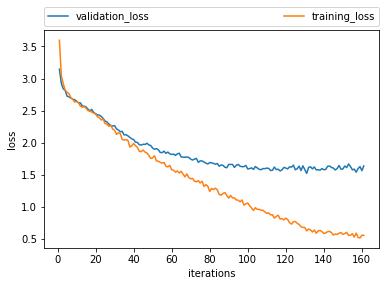

[3.145490426283616,
 2.9253711058543277,
 2.8403212565642137,
 2.8172881603240967,
 2.7264872239186215,
 2.715350554539607,
 2.6962661284666796,
 2.67744111097776,
 2.6704969864625197,
 2.6486841165102444,
 2.6216719975838294,
 2.6219261151093702,
 2.5747615649149966,
 2.568132473872258,
 2.5585996279349694,
 2.523704923116244,
 2.4963277761752787,
 2.519461200787471,
 2.4722088208565345,
 2.4537407893400927,
 2.4334505796432495,
 2.429544292963468,
 2.408608785042396,
 2.3783289102407603,
 2.3377301692962646,
 2.323886752128601,
 2.289684942135444,
 2.265043313686664,
 2.2609460904048038,
 2.2658037680845995,
 2.216299666808202,
 2.1986087010456967,
 2.170590478640336,
 2.1778621765283437,
 2.1214523865626407,
 2.1257453239881077,
 2.1075801849365234,
 2.083990372144259,
 2.059697517981896,
 2.050429880619049,
 2.008971338088696,
 2.0041795602211585,
 1.9685590725678663,
 1.9643835471226618,
 1.97599674646671,
 1.9731536507606506,
 1.9918190057461078,
 1.9666518981640155,
 1.956238003

In [36]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.709400329589844, validation_error:3.2040401697158813
Best loss improvement from inf to 3.2040401697158813 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0835375881195066, validation_error:2.9523570438226066
Best loss improvement from 3.2040401697158813 to 2.9523570438226066 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.928427047729492, validation_error:2.8752624293168387
Best loss improvement from 2.9523570438226066 to 2.8752624293168387 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.821950101852417, validation_error:2.8179062406222024
Best loss improvement from 2.8752624293168387 to 2.8179062406222024 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.7889968490600587, validation_error:2.79887256026268
Best loss improvement from 2.8179062406222024 to 2.79887256026268 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.772113995552063, validation

minibatch:35, epoch:12, iteration:2499, training_error:1.9884824323654176, validation_error:2.0621526738007865
Best loss improvement from 2.072996790210406 to 2.0621526738007865 in epoch 12
minibatch:85, epoch:12, iteration:2549, training_error:1.998761715888977, validation_error:2.0654133210579553
minibatch:135, epoch:12, iteration:2599, training_error:1.9472592782974243, validation_error:2.045606484015783
Best loss improvement from 2.0621526738007865 to 2.045606484015783 in epoch 12
minibatch:185, epoch:12, iteration:2649, training_error:1.9698177552223206, validation_error:2.0621229708194733
minibatch:11, epoch:13, iteration:2699, training_error:1.9287802457809449, validation_error:2.0563138922055564
minibatch:61, epoch:13, iteration:2749, training_error:1.9343239712715148, validation_error:2.0583225190639496
minibatch:111, epoch:13, iteration:2799, training_error:1.896703963279724, validation_error:2.0101963678995767
Best loss improvement from 2.045606484015783 to 2.010196367899576

minibatch:73, epoch:25, iteration:5449, training_error:1.3614403319358825, validation_error:1.756274625658989
minibatch:123, epoch:25, iteration:5499, training_error:1.3948181366920471, validation_error:1.759671151638031
minibatch:173, epoch:25, iteration:5549, training_error:1.354993234872818, validation_error:1.7658698707818985
minibatch:223, epoch:25, iteration:5599, training_error:1.3767837381362915, validation_error:1.7324116080999374
minibatch:49, epoch:26, iteration:5649, training_error:1.3714584982395173, validation_error:1.7406646609306335
minibatch:99, epoch:26, iteration:5699, training_error:1.3099644804000854, validation_error:1.6987234403689702
Best loss improvement from 1.7297440965970357 to 1.6987234403689702 in epoch 26
minibatch:149, epoch:26, iteration:5749, training_error:1.3443649864196778, validation_error:1.7542091856400173
minibatch:199, epoch:26, iteration:5799, training_error:1.314138023853302, validation_error:1.7389920701583226
minibatch:25, epoch:27, iterati

minibatch:113, epoch:40, iteration:8849, training_error:0.8902605152130127, validation_error:1.6591156323750813
minibatch:163, epoch:40, iteration:8899, training_error:0.8738391518592834, validation_error:1.6235496799151103
minibatch:213, epoch:40, iteration:8949, training_error:0.9005796551704407, validation_error:1.6642937511205673
minibatch:39, epoch:41, iteration:8999, training_error:0.8809275937080383, validation_error:1.6162310938040416
minibatch:89, epoch:41, iteration:9049, training_error:0.8904133367538453, validation_error:1.6421144902706146
minibatch:139, epoch:41, iteration:9099, training_error:0.8720833706855774, validation_error:1.603057141105334
Best loss improvement from 1.614528698225816 to 1.603057141105334 in epoch 41
minibatch:189, epoch:41, iteration:9149, training_error:0.8601500606536865, validation_error:1.6137692332267761
minibatch:15, epoch:42, iteration:9199, training_error:0.8504344558715821, validation_error:1.692225510875384
minibatch:65, epoch:42, iterati

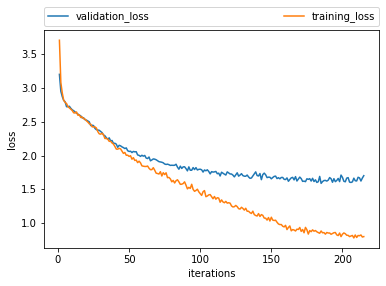

[3.2040401697158813,
 2.9523570438226066,
 2.8752624293168387,
 2.8179062406222024,
 2.79887256026268,
 2.725063383579254,
 2.7251893281936646,
 2.7313497364521027,
 2.7016585369904837,
 2.6791499157746634,
 2.6658284862836203,
 2.6482738256454468,
 2.6305370330810547,
 2.6165421108404794,
 2.598872661590576,
 2.589412808418274,
 2.5576967000961304,
 2.561496376991272,
 2.531068583329519,
 2.526391843954722,
 2.5132592022418976,
 2.500401814778646,
 2.4455742239952087,
 2.4503271778424582,
 2.4454855918884277,
 2.4024481177330017,
 2.384472260872523,
 2.3791373868783317,
 2.374952713648478,
 2.357012609640757,
 2.3405326108137765,
 2.306787004073461,
 2.293730214238167,
 2.26539808511734,
 2.243278125921885,
 2.2637501657009125,
 2.217794746160507,
 2.224540372689565,
 2.181419610977173,
 2.18349818388621,
 2.1694733848174415,
 2.12332650522391,
 2.153066173195839,
 2.145050674676895,
 2.12954610089461,
 2.1192061603069305,
 2.104677195350329,
 2.114816516637802,
 2.072996790210406,
 2

In [37]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 0, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.5915231227874758, validation_error:3.2493985052461976
Best loss improvement from inf to 3.2493985052461976 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0193991661071777, validation_error:2.958688665319372
Best loss improvement from 3.2493985052461976 to 2.958688665319372 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.931147027015686, validation_error:2.8759176466200085
Best loss improvement from 2.958688665319372 to 2.8759176466200085 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8385452365875246, validation_error:2.8173282146453857
Best loss improvement from 2.8759176466200085 to 2.8173282146453857 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.79453742980957, validation_error:2.7464696831173367
Best loss improvement from 2.8173282146453857 to 2.7464696831173367 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.7488749599456788, validati

minibatch:109, epoch:11, iteration:2499, training_error:1.9461047387123107, validation_error:2.0295236110687256
minibatch:159, epoch:11, iteration:2549, training_error:1.8888835072517396, validation_error:2.0225288426434553
minibatch:209, epoch:11, iteration:2599, training_error:1.9256140351295472, validation_error:1.9856064452065363
Best loss improvement from 2.0162264108657837 to 1.9856064452065363 in epoch 11
minibatch:20, epoch:12, iteration:2649, training_error:1.8702361345291139, validation_error:1.992788592974345
minibatch:70, epoch:12, iteration:2699, training_error:1.8279392838478088, validation_error:1.9896369333620425
minibatch:120, epoch:12, iteration:2749, training_error:1.8470133233070374, validation_error:1.9853400742566143
Best loss improvement from 1.9856064452065363 to 1.9853400742566143 in epoch 12
minibatch:170, epoch:12, iteration:2799, training_error:1.8349425435066222, validation_error:1.9672943662714075
Best loss improvement from 1.9853400742566143 to 1.96729436

minibatch:191, epoch:23, iteration:5449, training_error:1.3413867950439453, validation_error:1.6992034514745076
minibatch:2, epoch:24, iteration:5499, training_error:1.3492728161811829, validation_error:1.702029784520467
minibatch:52, epoch:24, iteration:5549, training_error:1.3225639474391937, validation_error:1.7099474668502808
minibatch:102, epoch:24, iteration:5599, training_error:1.2981213700771332, validation_error:1.6544999943839178
Best loss improvement from 1.6953951208679765 to 1.6544999943839178 in epoch 24
minibatch:152, epoch:24, iteration:5649, training_error:1.3414987552165984, validation_error:1.6783913727159854
minibatch:202, epoch:24, iteration:5699, training_error:1.2911624145507812, validation_error:1.6731994946797688
minibatch:13, epoch:25, iteration:5749, training_error:1.3409014856815338, validation_error:1.6996943906501487
minibatch:63, epoch:25, iteration:5799, training_error:1.2681862306594849, validation_error:1.7127786963074296
minibatch:113, epoch:25, itera

minibatch:184, epoch:36, iteration:8549, training_error:1.018120640516281, validation_error:1.5698589042381004
minibatch:234, epoch:36, iteration:8599, training_error:1.0283909130096436, validation_error:1.5697190364201863
minibatch:45, epoch:37, iteration:8649, training_error:1.055514155626297, validation_error:1.5581040029172544
minibatch:95, epoch:37, iteration:8699, training_error:1.030002738237381, validation_error:1.566084000799391
minibatch:145, epoch:37, iteration:8749, training_error:1.0114521968364716, validation_error:1.5536316809830841
minibatch:195, epoch:37, iteration:8799, training_error:1.024604150056839, validation_error:1.534389579737628
Best loss improvement from 1.5418806605868869 to 1.534389579737628 in epoch 37
minibatch:6, epoch:38, iteration:8849, training_error:1.0451954436302184, validation_error:1.596780366367764
minibatch:56, epoch:38, iteration:8899, training_error:1.0039803421497344, validation_error:1.5429405547954418
minibatch:106, epoch:38, iteration:89

minibatch:99, epoch:51, iteration:12049, training_error:0.8908478736877441, validation_error:1.5780411605481748
minibatch:149, epoch:51, iteration:12099, training_error:0.8779868066310883, validation_error:1.5298655077263161
minibatch:199, epoch:51, iteration:12149, training_error:0.9330736017227172, validation_error:1.534559060026098
minibatch:10, epoch:52, iteration:12199, training_error:0.8847514390945435, validation_error:1.521166914039188
minibatch:60, epoch:52, iteration:12249, training_error:0.8817573726177216, validation_error:1.5286026972311515
minibatch:110, epoch:52, iteration:12299, training_error:0.9188537931442261, validation_error:1.5039400833624381
minibatch:160, epoch:52, iteration:12349, training_error:0.9332065582275391, validation_error:1.522326319305985
minibatch:210, epoch:52, iteration:12399, training_error:0.8898328447341919, validation_error:1.5350912102946528
minibatch:21, epoch:53, iteration:12449, training_error:0.93689901471138, validation_error:1.551037870

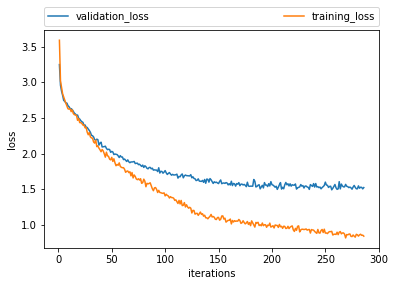

[3.2493985052461976,
 2.958688665319372,
 2.8759176466200085,
 2.8173282146453857,
 2.7464696831173367,
 2.733292756257234,
 2.7109078213020608,
 2.708757338700471,
 2.672249714533488,
 2.657368024190267,
 2.6324527705157243,
 2.6294943933133728,
 2.617919674626103,
 2.593899929964984,
 2.567214683250145,
 2.5546369464309127,
 2.5369650346261485,
 2.5404150044476546,
 2.495853715472751,
 2.4843387250547058,
 2.4614328101829246,
 2.4471740546049894,
 2.4379223629280373,
 2.396285507414076,
 2.401074868661386,
 2.3690727021959095,
 2.366378572252062,
 2.3436630037095814,
 2.323816493705467,
 2.298016813066271,
 2.255724968733611,
 2.2501285120292946,
 2.2332978425202548,
 2.1951038616674916,
 2.1880021580943354,
 2.201204785594234,
 2.1951013803482056,
 2.117405926739728,
 2.14709785691014,
 2.159275209462201,
 2.092139654689365,
 2.094089402092828,
 2.097022529001589,
 2.102993161590011,
 2.072554270426432,
 2.0544893741607666,
 2.059906244277954,
 2.056185413289953,
 2.0162264108657837

In [38]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 1, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.606919231414795, validation_error:3.180587724403099
Best loss improvement from inf to 3.180587724403099 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.026312928199768, validation_error:2.92133860234861
Best loss improvement from 3.180587724403099 to 2.92133860234861 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8637575054168702, validation_error:2.8527667345824064
Best loss improvement from 2.92133860234861 to 2.8527667345824064 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8494623947143554, validation_error:2.7943119826140226
Best loss improvement from 2.8527667345824064 to 2.7943119826140226 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.768054738044739, validation_error:2.7428885565863714
Best loss improvement from 2.7943119826140226 to 2.7428885565863714 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.713096470832825, validation_erro

minibatch:216, epoch:10, iteration:2349, training_error:1.9925668931007385, validation_error:2.066609369383918
minibatch:29, epoch:11, iteration:2399, training_error:1.982626554965973, validation_error:2.039340266474971
Best loss improvement from 2.0566508814140603 to 2.039340266474971 in epoch 11
minibatch:79, epoch:11, iteration:2449, training_error:1.9530775237083435, validation_error:2.0494112262019404
minibatch:129, epoch:11, iteration:2499, training_error:1.961153564453125, validation_error:2.0506975474180997
minibatch:179, epoch:11, iteration:2549, training_error:1.9259072947502136, validation_error:2.012836964042098
Best loss improvement from 2.039340266474971 to 2.012836964042098 in epoch 11
minibatch:229, epoch:11, iteration:2599, training_error:1.9531923270225524, validation_error:2.0138738287819757
minibatch:42, epoch:12, iteration:2649, training_error:1.936645474433899, validation_error:1.9933176128952592
Best loss improvement from 2.012836964042098 to 1.9933176128952592 i

minibatch:222, epoch:22, iteration:5199, training_error:1.4307234859466553, validation_error:1.7282059148505882
minibatch:35, epoch:23, iteration:5249, training_error:1.4492979502677918, validation_error:1.7257132574363991
Best loss improvement from 1.7257244057125516 to 1.7257132574363991 in epoch 23
minibatch:85, epoch:23, iteration:5299, training_error:1.4355678176879882, validation_error:1.6958803203370836
Best loss improvement from 1.7257132574363991 to 1.6958803203370836 in epoch 23
minibatch:135, epoch:23, iteration:5349, training_error:1.3773500967025756, validation_error:1.730936778916253
minibatch:185, epoch:23, iteration:5399, training_error:1.4032366561889649, validation_error:1.7140214045842488
minibatch:235, epoch:23, iteration:5449, training_error:1.4004428052902222, validation_error:1.7025031469486378
minibatch:48, epoch:24, iteration:5499, training_error:1.3763440322875977, validation_error:1.6861497119620994
Best loss improvement from 1.6958803203370836 to 1.686149711

minibatch:67, epoch:37, iteration:8599, training_error:1.0948112881183625, validation_error:1.5835077276936285
minibatch:117, epoch:37, iteration:8649, training_error:1.0860532701015473, validation_error:1.5978057163733024
minibatch:167, epoch:37, iteration:8699, training_error:1.1001915872097014, validation_error:1.5818197087005332
minibatch:217, epoch:37, iteration:8749, training_error:1.0522073495388031, validation_error:1.6282045752913863
minibatch:30, epoch:38, iteration:8799, training_error:1.0959773349761963, validation_error:1.6545536738854867
minibatch:80, epoch:38, iteration:8849, training_error:1.0788479387760161, validation_error:1.6396394791426483
minibatch:130, epoch:38, iteration:8899, training_error:1.0907475817203522, validation_error:1.5747644239001803
minibatch:180, epoch:38, iteration:8949, training_error:1.0532127130031586, validation_error:1.5995375050438776
minibatch:230, epoch:38, iteration:8999, training_error:1.0637141895294189, validation_error:1.586349191489

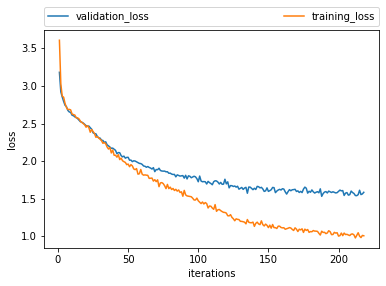

[3.180587724403099,
 2.92133860234861,
 2.8527667345824064,
 2.7943119826140226,
 2.7428885565863714,
 2.7251269464139587,
 2.6746813456217446,
 2.6542358663347034,
 2.647561956334997,
 2.6103092476173684,
 2.6043647042027227,
 2.5879333284166126,
 2.579919594305533,
 2.5643893347846136,
 2.544256572370176,
 2.523354415540342,
 2.517316049999661,
 2.5060898198021784,
 2.488942755593194,
 2.472186221016778,
 2.4642467940295183,
 2.4662953041217945,
 2.443694132345694,
 2.4242555565304227,
 2.3764819657361067,
 2.3660408390892878,
 2.363253708238955,
 2.328711394910459,
 2.309393463311372,
 2.3057419414873475,
 2.2783343217991017,
 2.2747841057954012,
 2.248290918491505,
 2.256942704871849,
 2.2166056059024952,
 2.202994364279288,
 2.1875190205044217,
 2.170709698288529,
 2.1727654139200845,
 2.158027414922361,
 2.1432468317173146,
 2.0981165832943387,
 2.113803814958643,
 2.11152129261582,
 2.073137746916877,
 2.0566508814140603,
 2.066609369383918,
 2.039340266474971,
 2.04941122620194

In [39]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 2, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.6023518562316896, validation_error:3.1982839990545204
Best loss improvement from inf to 3.1982839990545204 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0917034912109376, validation_error:2.928792529635959
Best loss improvement from 3.1982839990545204 to 2.928792529635959 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8846191787719726, validation_error:2.8389252380088523
Best loss improvement from 2.928792529635959 to 2.8389252380088523 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8455265665054323, validation_error:2.77688616293448
Best loss improvement from 2.8389252380088523 to 2.77688616293448 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.7797413539886473, validation_error:2.738398693226002
Best loss improvement from 2.77688616293448 to 2.738398693226002 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.723923168182373, validation_erro

minibatch:180, epoch:10, iteration:2349, training_error:2.0445439219474792, validation_error:2.08170994564339
minibatch:230, epoch:10, iteration:2399, training_error:2.0027592182159424, validation_error:2.043597442132455
Best loss improvement from 2.0510388524444014 to 2.043597442132455 in epoch 10
minibatch:39, epoch:11, iteration:2449, training_error:1.9792074275016784, validation_error:2.0136961053918907
Best loss improvement from 2.043597442132455 to 2.0136961053918907 in epoch 11
minibatch:89, epoch:11, iteration:2499, training_error:1.974049301147461, validation_error:2.0278998215993247
minibatch:139, epoch:11, iteration:2549, training_error:1.93962336063385, validation_error:2.0150289138158164
minibatch:189, epoch:11, iteration:2599, training_error:1.952470817565918, validation_error:2.014717362545155
minibatch:239, epoch:11, iteration:2649, training_error:1.944185161590576, validation_error:1.991575351467839
Best loss improvement from 2.0136961053918907 to 1.991575351467839 in 

minibatch:138, epoch:22, iteration:5199, training_error:1.4487953114509582, validation_error:1.732701884375678
minibatch:188, epoch:22, iteration:5249, training_error:1.4764390039443969, validation_error:1.7296674207404807
minibatch:238, epoch:22, iteration:5299, training_error:1.4719663882255554, validation_error:1.7551407593267936
minibatch:47, epoch:23, iteration:5349, training_error:1.4170596647262572, validation_error:1.730869836277432
minibatch:97, epoch:23, iteration:5399, training_error:1.4181730651855469, validation_error:1.6876934104495578
Best loss improvement from 1.71320962022852 to 1.6876934104495578 in epoch 23
minibatch:147, epoch:23, iteration:5449, training_error:1.3927299618721007, validation_error:1.7241633159142953
minibatch:197, epoch:23, iteration:5499, training_error:1.393540095090866, validation_error:1.7460471524132624
minibatch:6, epoch:24, iteration:5549, training_error:1.436286826133728, validation_error:1.7234239489943892
minibatch:56, epoch:24, iteration:

minibatch:64, epoch:36, iteration:8499, training_error:1.1295596492290496, validation_error:1.5860988828870985
minibatch:114, epoch:36, iteration:8549, training_error:1.1382774674892426, validation_error:1.6194212569130793
minibatch:164, epoch:36, iteration:8599, training_error:1.1070569777488708, validation_error:1.6050424664108842
minibatch:214, epoch:36, iteration:8649, training_error:1.080318729877472, validation_error:1.5715048489747223
minibatch:23, epoch:37, iteration:8699, training_error:1.0924829733371735, validation_error:1.5798451370663114
minibatch:73, epoch:37, iteration:8749, training_error:1.0715093982219697, validation_error:1.5904629186347679
minibatch:123, epoch:37, iteration:8799, training_error:1.0848990416526794, validation_error:1.5913937356736925
minibatch:173, epoch:37, iteration:8849, training_error:1.1463097357749938, validation_error:1.5810125624691997
minibatch:223, epoch:37, iteration:8899, training_error:1.0985014891624452, validation_error:1.5702014190179

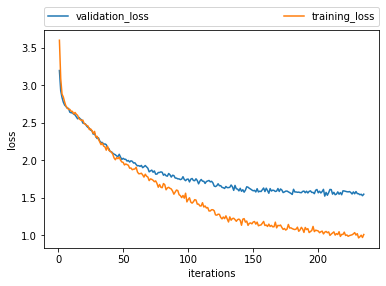

[3.1982839990545204,
 2.928792529635959,
 2.8389252380088523,
 2.77688616293448,
 2.738398693226002,
 2.719932927025689,
 2.695663222560176,
 2.6932800345950656,
 2.643095193085847,
 2.6356766665423357,
 2.63355799957558,
 2.6165580572905363,
 2.6073070013964617,
 2.579969538582696,
 2.5547528796725802,
 2.573791397942437,
 2.553092435554222,
 2.5413729261468956,
 2.498249407167788,
 2.4915010222682246,
 2.486157452618634,
 2.456586069530911,
 2.4388612376319037,
 2.4306337303585477,
 2.4042831350255898,
 2.395673901946456,
 2.350025759802924,
 2.360266614843298,
 2.316942409232811,
 2.2919117433053477,
 2.3015476288618864,
 2.259781493080987,
 2.2384511011618153,
 2.239918426231102,
 2.2159060372246637,
 2.2201326158311634,
 2.20998630700288,
 2.167789516625581,
 2.1576784451802573,
 2.118107654430248,
 2.115455159434566,
 2.0967485860542014,
 2.0834821550934404,
 2.0755815417678267,
 2.0592080928661205,
 2.0510388524444014,
 2.08170994564339,
 2.043597442132455,
 2.0136961053918907,


In [40]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 3, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.6541521167755127, validation_error:3.132680296897888
Best loss improvement from inf to 3.132680296897888 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.9925604391098024, validation_error:2.987606461231525
Best loss improvement from 3.132680296897888 to 2.987606461231525 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.9493466234207153, validation_error:2.820929059615502
Best loss improvement from 2.987606461231525 to 2.820929059615502 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8332169008255006, validation_error:2.775037224476154
Best loss improvement from 2.820929059615502 to 2.775037224476154 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.7433878135681153, validation_error:2.7314324103868923
Best loss improvement from 2.775037224476154 to 2.7314324103868923 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.7659384059906005, validation_err

minibatch:129, epoch:11, iteration:2449, training_error:1.906042559146881, validation_error:1.9795566980655377
Best loss improvement from 1.9881418209809523 to 1.9795566980655377 in epoch 11
minibatch:179, epoch:11, iteration:2499, training_error:1.8887257862091065, validation_error:1.9746262385294988
Best loss improvement from 1.9795566980655377 to 1.9746262385294988 in epoch 11
minibatch:229, epoch:11, iteration:2549, training_error:1.8758002614974976, validation_error:1.9565276870360742
Best loss improvement from 1.9746262385294988 to 1.9565276870360742 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.863792815208435, validation_error:1.9314699998268714
Best loss improvement from 1.9565276870360742 to 1.9314699998268714 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:1.8676182889938355, validation_error:1.9439807213269746
minibatch:147, epoch:12, iteration:2699, training_error:1.8400957298278808, validation_error:1.9095238813987145
Best loss im

minibatch:145, epoch:23, iteration:5249, training_error:1.320278069972992, validation_error:1.6116452858998225
minibatch:195, epoch:23, iteration:5299, training_error:1.3314411664009094, validation_error:1.6059001409090483
minibatch:13, epoch:24, iteration:5349, training_error:1.3206815457344054, validation_error:1.5889715414780836
Best loss improvement from 1.5999513085071857 to 1.5889715414780836 in epoch 24
minibatch:63, epoch:24, iteration:5399, training_error:1.3408602809906005, validation_error:1.5871620086523204
Best loss improvement from 1.5889715414780836 to 1.5871620086523204 in epoch 24
minibatch:113, epoch:24, iteration:5449, training_error:1.320833284854889, validation_error:1.6074652671813965
minibatch:163, epoch:24, iteration:5499, training_error:1.2686298310756683, validation_error:1.593113729586968
minibatch:213, epoch:24, iteration:5549, training_error:1.2613312339782714, validation_error:1.6257090339293847
minibatch:31, epoch:25, iteration:5599, training_error:1.2606

minibatch:147, epoch:37, iteration:8499, training_error:0.905002772808075, validation_error:1.4542721578708062
minibatch:197, epoch:37, iteration:8549, training_error:0.9107854485511779, validation_error:1.4703690593059247
minibatch:15, epoch:38, iteration:8599, training_error:0.908383572101593, validation_error:1.4868084627848406
minibatch:65, epoch:38, iteration:8649, training_error:0.9054532325267792, validation_error:1.4142794517370372
Best loss improvement from 1.4358208087774424 to 1.4142794517370372 in epoch 38
minibatch:115, epoch:38, iteration:8699, training_error:0.9020232689380646, validation_error:1.4775240283745985
minibatch:165, epoch:38, iteration:8749, training_error:0.8902581202983856, validation_error:1.490021710212414
minibatch:215, epoch:38, iteration:8799, training_error:0.8987373208999634, validation_error:1.4597555032143226
minibatch:33, epoch:39, iteration:8849, training_error:0.9206334793567658, validation_error:1.4328956328905547
minibatch:83, epoch:39, iterat

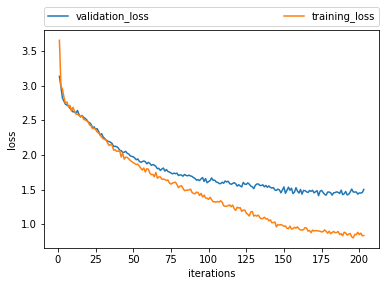

[3.132680296897888,
 2.987606461231525,
 2.820929059615502,
 2.775037224476154,
 2.7314324103868923,
 2.7196066287847667,
 2.711614434535687,
 2.6733090235636783,
 2.650742539992699,
 2.6218587435208836,
 2.6231246636464047,
 2.6057877173790565,
 2.6422898127482486,
 2.581611101443951,
 2.548978383724506,
 2.5701335118367123,
 2.543152543214651,
 2.5292615798803477,
 2.5102998935259304,
 2.4775573290311375,
 2.4660488825577955,
 2.4421161871690016,
 2.3916294941535363,
 2.406003181750958,
 2.368937217272245,
 2.3802446035238414,
 2.3389918345671434,
 2.287386573277987,
 2.3070070560161886,
 2.2604175255848813,
 2.2379748683709364,
 2.215863209504348,
 2.2008309089220486,
 2.192918919599973,
 2.1835183868041406,
 2.1645668607491713,
 2.1201787178332987,
 2.127175876727471,
 2.11956002162053,
 2.1033689104593716,
 2.0673721616084757,
 2.063476961392623,
 2.035223199771001,
 2.041064143180847,
 2.052126801930941,
 2.0243256046221805,
 2.0141638700778666,
 1.9881418209809523,
 1.9795566980

In [41]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 4, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.701564407348633, validation_error:3.1918141841888428
Best loss improvement from inf to 3.1918141841888428 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.080924701690674, validation_error:3.0467346608638763
Best loss improvement from 3.1918141841888428 to 3.0467346608638763 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.938465600013733, validation_error:2.8793464402357736
Best loss improvement from 3.0467346608638763 to 2.8793464402357736 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8785183811187744, validation_error:2.8096532225608826
Best loss improvement from 2.8793464402357736 to 2.8096532225608826 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.783269944190979, validation_error:2.8192927539348602
minibatch:75, epoch:2, iteration:299, training_error:2.780419225692749, validation_error:2.792820523182551
Best loss improvement from 2.8096532225608826 to 2.

minibatch:135, epoch:12, iteration:2599, training_error:2.160932950973511, validation_error:2.1525918394327164
minibatch:185, epoch:12, iteration:2649, training_error:2.16285863161087, validation_error:2.1201098610957465
Best loss improvement from 2.145819624265035 to 2.1201098610957465 in epoch 12
minibatch:11, epoch:13, iteration:2699, training_error:2.134323682785034, validation_error:2.110041454434395
Best loss improvement from 2.1201098610957465 to 2.110041454434395 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:2.126200120449066, validation_error:2.1074832330147424
Best loss improvement from 2.110041454434395 to 2.1074832330147424 in epoch 13
minibatch:111, epoch:13, iteration:2799, training_error:2.101304109096527, validation_error:2.1248310854037604
minibatch:161, epoch:13, iteration:2849, training_error:2.088339612483978, validation_error:2.145102938016256
minibatch:211, epoch:13, iteration:2899, training_error:2.0597315526008604, validation_error:2.1053449

minibatch:197, epoch:24, iteration:5349, training_error:1.7352269101142883, validation_error:1.8090865363677342
Best loss improvement from 1.8099611848592758 to 1.8090865363677342 in epoch 24
minibatch:23, epoch:25, iteration:5399, training_error:1.7423278546333314, validation_error:1.8179722428321838
minibatch:73, epoch:25, iteration:5449, training_error:1.726320457458496, validation_error:1.8057159582773845
Best loss improvement from 1.8090865363677342 to 1.8057159582773845 in epoch 25
minibatch:123, epoch:25, iteration:5499, training_error:1.7020964407920838, validation_error:1.8255932082732518
minibatch:173, epoch:25, iteration:5549, training_error:1.7207652115821839, validation_error:1.789917066693306
Best loss improvement from 1.8057159582773845 to 1.789917066693306 in epoch 25
minibatch:223, epoch:25, iteration:5599, training_error:1.7215187549591064, validation_error:1.7986157437165577
minibatch:49, epoch:26, iteration:5649, training_error:1.6634726929664612, validation_error:1

minibatch:211, epoch:38, iteration:8499, training_error:1.364419002532959, validation_error:1.5814536611239116
Best loss improvement from 1.6200447330872219 to 1.5814536611239116 in epoch 38
minibatch:37, epoch:39, iteration:8549, training_error:1.383581223487854, validation_error:1.6657000581423442
minibatch:87, epoch:39, iteration:8599, training_error:1.3360881090164185, validation_error:1.5994964838027954
minibatch:137, epoch:39, iteration:8649, training_error:1.3423719882965088, validation_error:1.6352994590997696
minibatch:187, epoch:39, iteration:8699, training_error:1.3497100150585175, validation_error:1.615531047185262
minibatch:13, epoch:40, iteration:8749, training_error:1.379606626033783, validation_error:1.617249717315038
minibatch:63, epoch:40, iteration:8799, training_error:1.3762080574035644, validation_error:1.6025268981854122
minibatch:113, epoch:40, iteration:8849, training_error:1.3398217463493347, validation_error:1.6366014381249745
minibatch:163, epoch:40, iteratio

minibatch:201, epoch:53, iteration:11849, training_error:1.2504502844810486, validation_error:1.4982621669769287
Best loss improvement from 1.510658745964368 to 1.4982621669769287 in epoch 53
minibatch:27, epoch:54, iteration:11899, training_error:1.2051502418518067, validation_error:1.515466146171093
minibatch:77, epoch:54, iteration:11949, training_error:1.2349988079071046, validation_error:1.5654287487268448
minibatch:127, epoch:54, iteration:11999, training_error:1.2428053629398346, validation_error:1.5342824707428615
minibatch:177, epoch:54, iteration:12049, training_error:1.219569364786148, validation_error:1.5400424351294835
minibatch:3, epoch:55, iteration:12099, training_error:1.2272406554222106, validation_error:1.5153404921293259
minibatch:53, epoch:55, iteration:12149, training_error:1.2424231958389282, validation_error:1.510909120241801
minibatch:103, epoch:55, iteration:12199, training_error:1.2152182853221893, validation_error:1.514829198519389
minibatch:153, epoch:55, i

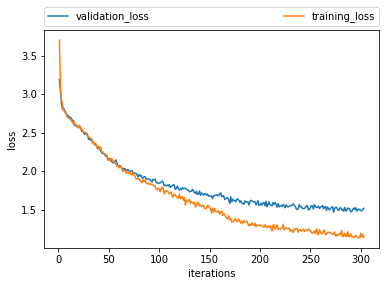

[3.1918141841888428,
 3.0467346608638763,
 2.8793464402357736,
 2.8096532225608826,
 2.8192927539348602,
 2.792820523182551,
 2.7710518340269723,
 2.734456996122996,
 2.727308839559555,
 2.7159909506638846,
 2.694552411635717,
 2.6994916101296744,
 2.6836010416348777,
 2.6536540389060974,
 2.6556748847166696,
 2.59182341893514,
 2.604184905687968,
 2.5960304935773215,
 2.5866637925306954,
 2.574957996606827,
 2.5675950845082602,
 2.569528122742971,
 2.516354570786158,
 2.523033946752548,
 2.500895082950592,
 2.475495755672455,
 2.496229112148285,
 2.4932273825009665,
 2.464451382557551,
 2.4115465184052787,
 2.4340101778507233,
 2.3976475298404694,
 2.4091696242491403,
 2.388190597295761,
 2.366699457168579,
 2.343578279018402,
 2.339299460252126,
 2.318621297677358,
 2.2914712677399316,
 2.3015836576620736,
 2.3168558279673257,
 2.2559046943982444,
 2.2385234783093133,
 2.2284040252367654,
 2.2294862419366837,
 2.2104198336601257,
 2.194279799858729,
 2.2049522598584494,
 2.1458196242

In [42]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 0, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.695685920715332, validation_error:3.186197598775228
Best loss improvement from inf to 3.186197598775228 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0490953731536865, validation_error:2.9570023307093867
Best loss improvement from 3.186197598775228 to 2.9570023307093867 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8537682914733886, validation_error:2.916509336895413
Best loss improvement from 2.9570023307093867 to 2.916509336895413 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.8424786901474, validation_error:2.822143563517818
Best loss improvement from 2.916509336895413 to 2.822143563517818 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.809709005355835, validation_error:2.748621622721354
Best loss improvement from 2.822143563517818 to 2.748621622721354 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.728319454193115, validation_error:2.

minibatch:9, epoch:11, iteration:2399, training_error:2.091773626804352, validation_error:2.1277774969736734
minibatch:59, epoch:11, iteration:2449, training_error:2.0865245413780213, validation_error:2.1256409927650735
minibatch:109, epoch:11, iteration:2499, training_error:2.075677673816681, validation_error:2.0833477399967335
Best loss improvement from 2.1250970407768532 to 2.0833477399967335 in epoch 11
minibatch:159, epoch:11, iteration:2549, training_error:2.082250714302063, validation_error:2.098956757121616
minibatch:209, epoch:11, iteration:2599, training_error:2.0508036327362063, validation_error:2.0639653470781116
Best loss improvement from 2.0833477399967335 to 2.0639653470781116 in epoch 11
minibatch:20, epoch:12, iteration:2649, training_error:2.062650501728058, validation_error:2.0851928260591297
minibatch:70, epoch:12, iteration:2699, training_error:2.0350901603698732, validation_error:2.0525207342924894
Best loss improvement from 2.0639653470781116 to 2.052520734292489

minibatch:130, epoch:22, iteration:5149, training_error:1.6882783627510072, validation_error:1.784752991464403
minibatch:180, epoch:22, iteration:5199, training_error:1.6425792384147644, validation_error:1.7816803146291662
minibatch:230, epoch:22, iteration:5249, training_error:1.6985924577713012, validation_error:1.7621885493949607
minibatch:41, epoch:23, iteration:5299, training_error:1.6361024761199952, validation_error:1.7532406780454848
Best loss improvement from 1.7571644473958898 to 1.7532406780454848 in epoch 23
minibatch:91, epoch:23, iteration:5349, training_error:1.671942572593689, validation_error:1.7923803947590016
minibatch:141, epoch:23, iteration:5399, training_error:1.6121026802062988, validation_error:1.781935003068712
minibatch:191, epoch:23, iteration:5449, training_error:1.6670144176483155, validation_error:1.765552904870775
minibatch:2, epoch:24, iteration:5499, training_error:1.650396704673767, validation_error:1.7460280480208221
Best loss improvement from 1.7532

minibatch:223, epoch:35, iteration:8349, training_error:1.4125432169437409, validation_error:1.6426074593155473
Patience ran out at 8349. Finetuning, and improving patience.
minibatch:34, epoch:36, iteration:8399, training_error:1.3679087281227111, validation_error:1.5832756183765553
Best loss improvement from 1.6118090196892068 to 1.5832756183765553 in epoch 36
minibatch:84, epoch:36, iteration:8449, training_error:1.38622389793396, validation_error:1.564706321115847
Best loss improvement from 1.5832756183765553 to 1.564706321115847 in epoch 36
minibatch:134, epoch:36, iteration:8499, training_error:1.3616984510421752, validation_error:1.5711531815705475
minibatch:184, epoch:36, iteration:8549, training_error:1.316074492931366, validation_error:1.5899962584177654
minibatch:234, epoch:36, iteration:8599, training_error:1.3471024930477142, validation_error:1.5585113101535373
Best loss improvement from 1.564706321115847 to 1.5585113101535373 in epoch 36
minibatch:45, epoch:37, iteration:

minibatch:77, epoch:49, iteration:11549, training_error:1.2189733755588532, validation_error:1.4859180847803752
minibatch:127, epoch:49, iteration:11599, training_error:1.2239648938179015, validation_error:1.4438040874622486
Best loss improvement from 1.4537957244449191 to 1.4438040874622486 in epoch 49
minibatch:177, epoch:49, iteration:11649, training_error:1.2224759078025818, validation_error:1.459147850672404
minibatch:227, epoch:49, iteration:11699, training_error:1.1938214409351349, validation_error:1.4824744551270097
minibatch:38, epoch:50, iteration:11749, training_error:1.2196044862270354, validation_error:1.4716197473031503
minibatch:88, epoch:50, iteration:11799, training_error:1.190591722726822, validation_error:1.4702877159471865
minibatch:138, epoch:50, iteration:11849, training_error:1.2059055805206298, validation_error:1.4714572694566515
minibatch:188, epoch:50, iteration:11899, training_error:1.2131257390975951, validation_error:1.4596294385415536
minibatch:238, epoch:

minibatch:181, epoch:63, iteration:14999, training_error:1.0934677088260651, validation_error:1.374529105645639
Best loss improvement from 1.3938582782392148 to 1.374529105645639 in epoch 63
minibatch:231, epoch:63, iteration:15049, training_error:1.1247512412071228, validation_error:1.4325976415916726
minibatch:42, epoch:64, iteration:15099, training_error:1.1145162606239318, validation_error:1.3846223133581657
minibatch:92, epoch:64, iteration:15149, training_error:1.1288999795913697, validation_error:1.4393941693835788
minibatch:142, epoch:64, iteration:15199, training_error:1.1322264540195466, validation_error:1.4242847517684654
minibatch:192, epoch:64, iteration:15249, training_error:1.1264092791080476, validation_error:1.4215603139665391
minibatch:3, epoch:65, iteration:15299, training_error:1.1442389690876007, validation_error:1.416967495724007
minibatch:53, epoch:65, iteration:15349, training_error:1.0903375399112702, validation_error:1.3778127476021096
minibatch:103, epoch:65,

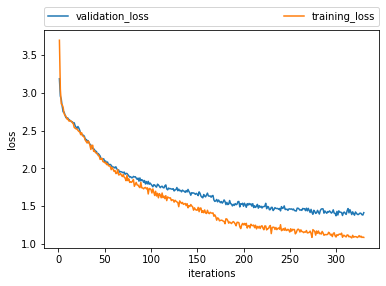

[3.186197598775228,
 2.9570023307093867,
 2.916509336895413,
 2.822143563517818,
 2.748621622721354,
 2.746847806153474,
 2.7083816528320312,
 2.6725428810826055,
 2.6693351710284197,
 2.667876534991794,
 2.649358360855668,
 2.639539868743331,
 2.630915747748481,
 2.6171074178483753,
 2.6176423496670194,
 2.5976917390470153,
 2.6042009636207863,
 2.564631047072234,
 2.544925248181378,
 2.5279905001322427,
 2.5547617188206426,
 2.533469208964595,
 2.5036136309305825,
 2.4618383425253407,
 2.458232429292467,
 2.439802787922047,
 2.4397434216958507,
 2.424549138104474,
 2.3835342725118003,
 2.383573638068305,
 2.3678339234104864,
 2.367942836549547,
 2.33758642938402,
 2.320291112970423,
 2.309029543841327,
 2.288686403521785,
 2.2637160045129283,
 2.2616009800522416,
 2.2465292480256824,
 2.2291817046977855,
 2.225058220050953,
 2.1892340624773943,
 2.197841666362904,
 2.180749460502907,
 2.1647698172816523,
 2.1280387375089855,
 2.1250970407768532,
 2.1277774969736734,
 2.12564099276507

In [43]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 1, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.6555249977111814, validation_error:3.1841834032977068
Best loss improvement from inf to 3.1841834032977068 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0363007259368895, validation_error:2.8944051883838795
Best loss improvement from 3.1841834032977068 to 2.8944051883838795 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8761579418182373, validation_error:2.8410668549714266
Best loss improvement from 2.8944051883838795 to 2.8410668549714266 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.815126905441284, validation_error:2.804788589477539
Best loss improvement from 2.8410668549714266 to 2.804788589477539 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.776378936767578, validation_error:2.746028520442821
Best loss improvement from 2.804788589477539 to 2.746028520442821 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.75429069519043, validation_

minibatch:29, epoch:11, iteration:2399, training_error:2.124912533760071, validation_error:2.151515664877715
minibatch:79, epoch:11, iteration:2449, training_error:2.0910971546173096, validation_error:2.0962093053040682
Best loss improvement from 2.100074534062986 to 2.0962093053040682 in epoch 11
minibatch:129, epoch:11, iteration:2499, training_error:2.0925268864631654, validation_error:2.091513196627299
Best loss improvement from 2.0962093053040682 to 2.091513196627299 in epoch 11
minibatch:179, epoch:11, iteration:2549, training_error:2.112684197425842, validation_error:2.110304916346515
minibatch:229, epoch:11, iteration:2599, training_error:2.091533169746399, validation_error:2.0741804661574186
Best loss improvement from 2.091513196627299 to 2.0741804661574186 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:2.061948528289795, validation_error:2.0806285981778747
minibatch:92, epoch:12, iteration:2699, training_error:2.0229053020477297, validation_error:2.0562029

minibatch:172, epoch:22, iteration:5149, training_error:1.716839165687561, validation_error:1.794021451914752
Best loss improvement from 1.7942882202289723 to 1.794021451914752 in epoch 22
minibatch:222, epoch:22, iteration:5199, training_error:1.6940929126739501, validation_error:1.7875082934344257
Best loss improvement from 1.794021451914752 to 1.7875082934344257 in epoch 22
minibatch:35, epoch:23, iteration:5249, training_error:1.7261364555358887, validation_error:1.812270548608568
minibatch:85, epoch:23, iteration:5299, training_error:1.73666086435318, validation_error:1.7998049965611211
minibatch:135, epoch:23, iteration:5349, training_error:1.6859483981132508, validation_error:1.7572262993565313
Best loss improvement from 1.7875082934344257 to 1.7572262993565313 in epoch 23
minibatch:185, epoch:23, iteration:5399, training_error:1.6711611652374267, validation_error:1.7833450856032196
minibatch:235, epoch:23, iteration:5449, training_error:1.716150574684143, validation_error:1.790

minibatch:104, epoch:36, iteration:8399, training_error:1.4419408655166626, validation_error:1.6673647165298462
minibatch:154, epoch:36, iteration:8449, training_error:1.4274545729160308, validation_error:1.6683900135534782
minibatch:204, epoch:36, iteration:8499, training_error:1.4452876138687134, validation_error:1.6411386419225622
Patience ran out at 8499. Finetuning, and improving patience.
minibatch:17, epoch:37, iteration:8549, training_error:1.440302791595459, validation_error:1.6188360585106745
Best loss improvement from 1.6313373225706596 to 1.6188360585106745 in epoch 37
minibatch:67, epoch:37, iteration:8599, training_error:1.3900515508651734, validation_error:1.6060613084722448
Best loss improvement from 1.6188360585106745 to 1.6060613084722448 in epoch 37
minibatch:117, epoch:37, iteration:8649, training_error:1.3373321402072906, validation_error:1.6197062024363764
minibatch:167, epoch:37, iteration:8699, training_error:1.3805545783042907, validation_error:1.55926611026128

minibatch:36, epoch:50, iteration:11649, training_error:1.2344150507450105, validation_error:1.5093325906329684
minibatch:86, epoch:50, iteration:11699, training_error:1.265357345342636, validation_error:1.543043639924791
minibatch:136, epoch:50, iteration:11749, training_error:1.2662046551704407, validation_error:1.5262187233677618
minibatch:186, epoch:50, iteration:11799, training_error:1.2373767757415772, validation_error:1.5358264667016488
minibatch:236, epoch:50, iteration:11849, training_error:1.2298859190940856, validation_error:1.5406588580873277
minibatch:49, epoch:51, iteration:11899, training_error:1.2526341593265533, validation_error:1.5191238853666518
minibatch:99, epoch:51, iteration:11949, training_error:1.2449995458126069, validation_error:1.515240024637293
minibatch:149, epoch:51, iteration:11999, training_error:1.2280906522274018, validation_error:1.5175289357150044
minibatch:199, epoch:51, iteration:12049, training_error:1.2190847671031952, validation_error:1.5056240

minibatch:31, epoch:65, iteration:15199, training_error:1.1992110788822175, validation_error:1.4959316827632763
minibatch:81, epoch:65, iteration:15249, training_error:1.1443261349201201, validation_error:1.466348855583756
minibatch:131, epoch:65, iteration:15299, training_error:1.147866859436035, validation_error:1.450268789573952
minibatch:181, epoch:65, iteration:15349, training_error:1.109225825071335, validation_error:1.499813477198283
minibatch:231, epoch:65, iteration:15399, training_error:1.147090356349945, validation_error:1.4470839654957806
minibatch:44, epoch:66, iteration:15449, training_error:1.1133552944660188, validation_error:1.4947583542929754
Patience ran out at 15449. Ending training


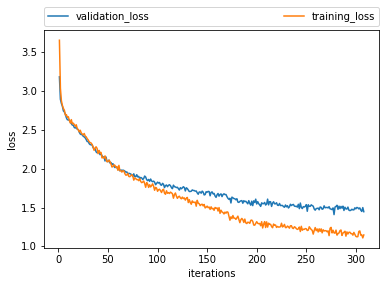

[3.1841834032977068,
 2.8944051883838795,
 2.8410668549714266,
 2.804788589477539,
 2.746028520442821,
 2.731810834672716,
 2.700629790623983,
 2.657547120694761,
 2.6313736880267107,
 2.6296085958127624,
 2.6250435687877514,
 2.5998203136302807,
 2.58192652243155,
 2.5625701833654335,
 2.5616499759532787,
 2.5314277984477855,
 2.52474398083157,
 2.5302932880542897,
 2.5096378679628724,
 2.5045589959179915,
 2.4721606042650013,
 2.44865083694458,
 2.4403107431199818,
 2.4401082815947355,
 2.418271612238001,
 2.410841297220301,
 2.397827872523555,
 2.37647756823787,
 2.3507620449419373,
 2.3518435955047607,
 2.3242949821330883,
 2.3111520255053484,
 2.3091402407045716,
 2.3071724662074335,
 2.271899766392178,
 2.2524499275066234,
 2.256964573153743,
 2.218406465318468,
 2.2054283265714294,
 2.223668513474641,
 2.225607540872362,
 2.1812260901486433,
 2.1912042697270713,
 2.1662793115333274,
 2.1530522637897067,
 2.1500949329800076,
 2.100074534062986,
 2.151515664877715,
 2.096209305304

In [44]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 2, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.629791121482849, validation_error:3.104737087532326
Best loss improvement from inf to 3.104737087532326 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0413317823410035, validation_error:2.9112075258184364
Best loss improvement from 3.104737087532326 to 2.9112075258184364 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.8910807847976683, validation_error:2.8287676175435386
Best loss improvement from 2.9112075258184364 to 2.8287676175435386 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.843461537361145, validation_error:2.8012289471096463
Best loss improvement from 2.8287676175435386 to 2.8012289471096463 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.8201103258132934, validation_error:2.7455709598682545
Best loss improvement from 2.8012289471096463 to 2.7455709598682545 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.7682088375091554, validati

minibatch:39, epoch:11, iteration:2449, training_error:2.1114454817771913, validation_error:2.082203436780859
Best loss improvement from 2.0961301547509654 to 2.082203436780859 in epoch 11
minibatch:89, epoch:11, iteration:2499, training_error:2.1176796841621397, validation_error:2.072215760195697
Best loss improvement from 2.082203436780859 to 2.072215760195697 in epoch 11
minibatch:139, epoch:11, iteration:2549, training_error:2.0926905775070193, validation_error:2.071820263509397
Best loss improvement from 2.072215760195697 to 2.071820263509397 in epoch 11
minibatch:189, epoch:11, iteration:2599, training_error:2.0488301491737366, validation_error:2.06416439127039
Best loss improvement from 2.071820263509397 to 2.06416439127039 in epoch 11
minibatch:239, epoch:11, iteration:2649, training_error:2.0901997017860414, validation_error:2.0390283973128707
Best loss improvement from 2.06416439127039 to 2.0390283973128707 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:2.

minibatch:229, epoch:21, iteration:5049, training_error:1.7475993680953978, validation_error:1.7878287544956915
minibatch:38, epoch:22, iteration:5099, training_error:1.7221868848800659, validation_error:1.803080607343603
minibatch:88, epoch:22, iteration:5149, training_error:1.7227065944671631, validation_error:1.7670612026143957
minibatch:138, epoch:22, iteration:5199, training_error:1.7283832764625549, validation_error:1.760096165868971
minibatch:188, epoch:22, iteration:5249, training_error:1.7109745311737061, validation_error:1.794231516343576
minibatch:238, epoch:22, iteration:5299, training_error:1.7082980608940124, validation_error:1.7569121034057051
Best loss improvement from 1.7592427995469835 to 1.7569121034057051 in epoch 22
minibatch:47, epoch:23, iteration:5349, training_error:1.706065547466278, validation_error:1.7571890751520793
minibatch:97, epoch:23, iteration:5399, training_error:1.705684280395508, validation_error:1.7825867202546861
minibatch:147, epoch:23, iteratio

minibatch:5, epoch:35, iteration:8199, training_error:1.4729490637779237, validation_error:1.691604353763439
minibatch:55, epoch:35, iteration:8249, training_error:1.4716148161888123, validation_error:1.646239232133936
minibatch:105, epoch:35, iteration:8299, training_error:1.4317214322090148, validation_error:1.6446668571896024
minibatch:155, epoch:35, iteration:8349, training_error:1.4738535499572754, validation_error:1.6388661640661735
minibatch:205, epoch:35, iteration:8399, training_error:1.438794445991516, validation_error:1.6458862490124173
minibatch:14, epoch:36, iteration:8449, training_error:1.4259819388389587, validation_error:1.6585163981826216
minibatch:64, epoch:36, iteration:8499, training_error:1.4140012955665588, validation_error:1.6597757736841838
minibatch:114, epoch:36, iteration:8549, training_error:1.4336610746383667, validation_error:1.6534252519960757
minibatch:164, epoch:36, iteration:8599, training_error:1.4134680104255677, validation_error:1.6267057436483878


minibatch:113, epoch:47, iteration:11199, training_error:1.2223464381694793, validation_error:1.4919167227215238
minibatch:163, epoch:47, iteration:11249, training_error:1.2674215972423553, validation_error:1.5015667058803417
minibatch:213, epoch:47, iteration:11299, training_error:1.1951621794700622, validation_error:1.5317132870356243
minibatch:22, epoch:48, iteration:11349, training_error:1.2481773138046264, validation_error:1.5453820846698902
minibatch:72, epoch:48, iteration:11399, training_error:1.2398761928081512, validation_error:1.498477542841876
minibatch:122, epoch:48, iteration:11449, training_error:1.253743498325348, validation_error:1.5172922964449282
minibatch:172, epoch:48, iteration:11499, training_error:1.2175986516475676, validation_error:1.4961422240292583
minibatch:222, epoch:48, iteration:11549, training_error:1.1687669146060944, validation_error:1.4754407979823925
Best loss improvement from 1.482840692555463 to 1.4754407979823925 in epoch 48
minibatch:31, epoch:4

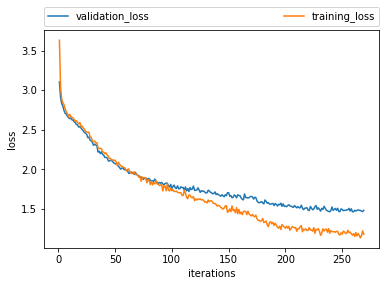

[3.104737087532326,
 2.9112075258184364,
 2.8287676175435386,
 2.8012289471096463,
 2.7455709598682545,
 2.709096873248065,
 2.699334073949743,
 2.6707280653494374,
 2.6547211187857167,
 2.6422290360486067,
 2.6488454695101136,
 2.6261956603438765,
 2.6230608092414007,
 2.603262353826452,
 2.588171923602069,
 2.5664855904049344,
 2.5600120932967574,
 2.5352536307440863,
 2.541628396069562,
 2.521752604731807,
 2.504009308638396,
 2.486270798577203,
 2.4690563325528747,
 2.458137777116564,
 2.444121828785649,
 2.401772066398903,
 2.4093974431355796,
 2.370135263160423,
 2.3601188924577503,
 2.342759026421441,
 2.305087716491134,
 2.3182857213196932,
 2.309710242130138,
 2.297517176027651,
 2.2190948680595115,
 2.230037773097003,
 2.1994043986002603,
 2.222802347607083,
 2.1910621060265436,
 2.181184861395094,
 2.1522232161627874,
 2.153988211243241,
 2.146555123505769,
 2.1092585501847445,
 2.1049068945425526,
 2.116772108607822,
 2.113012671470642,
 2.0961301547509654,
 2.0822034367808

In [45]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 3, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.6856367921829225, validation_error:3.2738111202533426
Best loss improvement from inf to 3.2738111202533426 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:3.0996140098571776, validation_error:2.9681887443249044
Best loss improvement from 3.2738111202533426 to 2.9681887443249044 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.897694706916809, validation_error:2.8687007885712843
Best loss improvement from 2.9681887443249044 to 2.8687007885712843 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.83444091796875, validation_error:2.8099890305445743
Best loss improvement from 2.8687007885712843 to 2.8099890305445743 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.7976464796066285, validation_error:2.745138636002174
Best loss improvement from 2.8099890305445743 to 2.745138636002174 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.764023871421814, validati

minibatch:179, epoch:11, iteration:2499, training_error:2.1019129872322084, validation_error:2.070082802038926
Best loss improvement from 2.0906963623487034 to 2.070082802038926 in epoch 11
minibatch:229, epoch:11, iteration:2549, training_error:2.0761165904998777, validation_error:2.0349890910662136
Best loss improvement from 2.070082802038926 to 2.0349890910662136 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:2.055691463947296, validation_error:2.051482622440045
minibatch:97, epoch:12, iteration:2649, training_error:2.0285502886772155, validation_error:2.0398029730870175
minibatch:147, epoch:12, iteration:2699, training_error:2.0373191595077516, validation_error:2.022131621837616
Best loss improvement from 2.0349890910662136 to 2.022131621837616 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:2.0118825149536135, validation_error:2.0164923117710996
Best loss improvement from 2.022131621837616 to 2.0164923117710996 in epoch 12
minibatch:15, epoc

minibatch:145, epoch:23, iteration:5249, training_error:1.6295473742485047, validation_error:1.6817992329597473
Best loss improvement from 1.6886669718302214 to 1.6817992329597473 in epoch 23
minibatch:195, epoch:23, iteration:5299, training_error:1.6220198392868042, validation_error:1.6963466635117164
minibatch:13, epoch:24, iteration:5349, training_error:1.6545298027992248, validation_error:1.663933304639963
Best loss improvement from 1.6817992329597473 to 1.663933304639963 in epoch 24
minibatch:63, epoch:24, iteration:5399, training_error:1.6228619456291198, validation_error:1.6755506900640635
minibatch:113, epoch:24, iteration:5449, training_error:1.6471764588356017, validation_error:1.6797971083567693
minibatch:163, epoch:24, iteration:5499, training_error:1.632287175655365, validation_error:1.6675268228237445
minibatch:213, epoch:24, iteration:5549, training_error:1.6105075192451477, validation_error:1.6584775310296278
Best loss improvement from 1.663933304639963 to 1.65847753102

minibatch:79, epoch:36, iteration:8199, training_error:1.316591091156006, validation_error:1.4841391811004052
Best loss improvement from 1.5275180614911592 to 1.4841391811004052 in epoch 36
minibatch:129, epoch:36, iteration:8249, training_error:1.3262739753723145, validation_error:1.4772762243564312
Best loss improvement from 1.4841391811004052 to 1.4772762243564312 in epoch 36
minibatch:179, epoch:36, iteration:8299, training_error:1.3129858434200288, validation_error:1.480115266946646
minibatch:229, epoch:36, iteration:8349, training_error:1.3103602027893066, validation_error:1.486160920216487
minibatch:47, epoch:37, iteration:8399, training_error:1.3288497292995454, validation_error:1.4915635218987098
minibatch:97, epoch:37, iteration:8449, training_error:1.2829411923885345, validation_error:1.470151594051948
Best loss improvement from 1.4772762243564312 to 1.470151594051948 in epoch 37
minibatch:147, epoch:37, iteration:8499, training_error:1.296219025850296, validation_error:1.48

minibatch:81, epoch:50, iteration:11449, training_error:1.1705005002021789, validation_error:1.3433968654045692
Best loss improvement from 1.3535951055013216 to 1.3433968654045692 in epoch 50
minibatch:131, epoch:50, iteration:11499, training_error:1.1990443134307862, validation_error:1.389606542312182
minibatch:181, epoch:50, iteration:11549, training_error:1.1790738248825072, validation_error:1.3684414281294897
minibatch:231, epoch:50, iteration:11599, training_error:1.1766234827041626, validation_error:1.3712979280031645
minibatch:49, epoch:51, iteration:11649, training_error:1.174965467453003, validation_error:1.362373989361983
minibatch:99, epoch:51, iteration:11699, training_error:1.2003763866424562, validation_error:1.3617703593694246
minibatch:149, epoch:51, iteration:11749, training_error:1.1808973455429077, validation_error:1.3762296759165251
minibatch:199, epoch:51, iteration:11799, training_error:1.17063241481781, validation_error:1.3867933108256414
minibatch:17, epoch:52, 

minibatch:51, epoch:65, iteration:14899, training_error:1.0788639295101166, validation_error:1.341476788887611
minibatch:101, epoch:65, iteration:14949, training_error:1.098590714931488, validation_error:1.3165026696828694
minibatch:151, epoch:65, iteration:14999, training_error:1.073227845430374, validation_error:1.3362914186257582
minibatch:201, epoch:65, iteration:15049, training_error:1.1374622809886932, validation_error:1.328923592200646
minibatch:19, epoch:66, iteration:15099, training_error:1.0778980565071106, validation_error:1.3040124407181373
minibatch:69, epoch:66, iteration:15149, training_error:1.099450684785843, validation_error:1.2906849269683545
minibatch:119, epoch:66, iteration:15199, training_error:1.0876442968845368, validation_error:1.3372978430527906
minibatch:169, epoch:66, iteration:15249, training_error:1.0756349289417266, validation_error:1.2735525071620941
Best loss improvement from 1.2873202516482427 to 1.2735525071620941 in epoch 66
minibatch:219, epoch:66,

minibatch:21, epoch:80, iteration:18349, training_error:1.0542226803302766, validation_error:1.282373506289262
minibatch:71, epoch:80, iteration:18399, training_error:1.0133618986606598, validation_error:1.2791899075874915
minibatch:121, epoch:80, iteration:18449, training_error:1.0169713163375855, validation_error:1.2844936366264637
minibatch:171, epoch:80, iteration:18499, training_error:1.0492525172233582, validation_error:1.2847543633901155
minibatch:221, epoch:80, iteration:18549, training_error:0.983005644083023, validation_error:1.2570681273937225
minibatch:39, epoch:81, iteration:18599, training_error:1.0774599730968475, validation_error:1.2804511831356928
minibatch:89, epoch:81, iteration:18649, training_error:1.0048418855667114, validation_error:1.266009475176151
minibatch:139, epoch:81, iteration:18699, training_error:0.9993277680873871, validation_error:1.2805767907546117
minibatch:189, epoch:81, iteration:18749, training_error:1.0079907155036927, validation_error:1.2837893

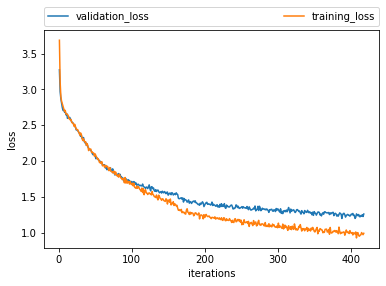

[3.2738111202533426,
 2.9681887443249044,
 2.8687007885712843,
 2.8099890305445743,
 2.745138636002174,
 2.7070852242983303,
 2.7142428985008826,
 2.6846862664589515,
 2.6873824321306667,
 2.6458550966702976,
 2.663598867563101,
 2.59790131678948,
 2.6081842275766225,
 2.6026651859283447,
 2.6117512629582333,
 2.5934768364979672,
 2.565773505430955,
 2.543943093373225,
 2.540566875384404,
 2.5223575922159047,
 2.5129239559173584,
 2.4818665247697096,
 2.4752187178685117,
 2.4373149505028358,
 2.435406941633958,
 2.4255134600859423,
 2.4151371809152455,
 2.39346300638639,
 2.378594609407278,
 2.3460644208467922,
 2.3670767545700073,
 2.3175770136026235,
 2.304580954404978,
 2.3304079862741323,
 2.2743675983869114,
 2.255657182290004,
 2.2661090722450843,
 2.2193686274381785,
 2.23496714922098,
 2.200420168729929,
 2.1826939903772793,
 2.167155678455646,
 2.1572291530095615,
 2.153729979808514,
 2.1344553919938893,
 2.107161819934845,
 2.091268392709585,
 2.09337527018327,
 2.09069636234

In [46]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'both', 4, 2, patience=10)

In [47]:
PATH="models/model_celeba_original_network.pt"

model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

#freeze_layer(model.fc1)

#freeze_layer(model.fc2)

print(model)

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


minibatch:49, epoch:1, iteration:49, training_error:0.8653708362579345, validation_error:0.740585466225942
Best loss improvement from inf to 0.740585466225942 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7213096511363983, validation_error:0.6930030098667851
Best loss improvement from 0.740585466225942 to 0.6930030098667851 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6865236735343934, validation_error:0.6669846530313845
Best loss improvement from 0.6930030098667851 to 0.6669846530313845 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6662750124931336, validation_error:0.6626915843398483
Best loss improvement from 0.6669846530313845 to 0.6626915843398483 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6401575195789337, validation_error:0.6505665977795919
Best loss improvement from 0.6626915843398483 to 0.6505665977795919 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6359257185459137, valida

minibatch:143, epoch:12, iteration:2849, training_error:0.19833750173449516, validation_error:0.40957454729963233
minibatch:193, epoch:12, iteration:2899, training_error:0.2103867456316948, validation_error:0.40333907968468136
minibatch:243, epoch:12, iteration:2949, training_error:0.2035653783380985, validation_error:0.4200063678953383
minibatch:47, epoch:13, iteration:2999, training_error:0.17868044435977937, validation_error:0.4047049123931814
minibatch:97, epoch:13, iteration:3049, training_error:0.16653549492359163, validation_error:0.41035846317255936
minibatch:147, epoch:13, iteration:3099, training_error:0.17940075799822808, validation_error:0.43420488525319983
minibatch:197, epoch:13, iteration:3149, training_error:0.17725442230701446, validation_error:0.41829102403587765
minibatch:1, epoch:14, iteration:3199, training_error:0.18769877076148986, validation_error:0.4025626900019469
Patience ran out at 3199. Finetuning, and improving patience.
minibatch:51, epoch:14, iteration:3

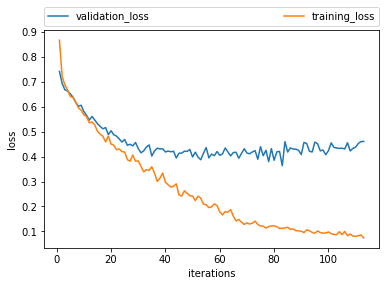

[0.740585466225942,
 0.6930030098667851,
 0.6669846530313845,
 0.6626915843398483,
 0.6505665977795919,
 0.6373980376455519,
 0.6167533066537645,
 0.6012291864112571,
 0.6052324506971571,
 0.5798530137097394,
 0.5649253748081349,
 0.5457584747561702,
 0.5605015787813399,
 0.5461071895228492,
 0.531067939820113,
 0.5205145334755933,
 0.5109605115872843,
 0.5158287474402675,
 0.4876866263371927,
 0.5032003577108737,
 0.48737819879143324,
 0.4817791603229664,
 0.47077449825074935,
 0.45799597656285324,
 0.4681190053621928,
 0.44517646233240765,
 0.44876676245971964,
 0.4426529374387529,
 0.456206187053963,
 0.43240339446950843,
 0.41496544193338464,
 0.42249838621528063,
 0.43762211391219386,
 0.4464878119804241,
 0.40193870001369053,
 0.42223060020694025,
 0.4334330647080033,
 0.43020983426659193,
 0.4309951552638301,
 0.41821226477622986,
 0.42183253941712556,
 0.41893918094811616,
 0.42117701526041385,
 0.3941304794064275,
 0.4133294180587486,
 0.41370600020443954,
 0.42135844186500265

In [48]:
# This is without replacing the last layer
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.9262863981723786, validation_error:0.7300998013595055
Best loss improvement from inf to 0.7300998013595055 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7064883363246918, validation_error:0.7094837838205797
Best loss improvement from 0.7300998013595055 to 0.7094837838205797 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7031173229217529, validation_error:0.6978219151496887
Best loss improvement from 0.7094837838205797 to 0.6978219151496887 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6690060997009277, validation_error:0.6554016892252297
Best loss improvement from 0.6978219151496887 to 0.6554016892252297 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6507052779197693, validation_error:0.6433247656657778
Best loss improvement from 0.6554016892252297 to 0.6433247656657778 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6211690330505371, v

minibatch:127, epoch:12, iteration:2899, training_error:0.20641111463308334, validation_error:0.39413141587684897
minibatch:177, epoch:12, iteration:2949, training_error:0.19758224979043007, validation_error:0.3976144153496315
minibatch:227, epoch:12, iteration:2999, training_error:0.19220767721533774, validation_error:0.3748178358735709
Best loss improvement from 0.3758178394416283 to 0.3748178358735709 in epoch 12
minibatch:25, epoch:13, iteration:3049, training_error:0.18908753782510757, validation_error:0.3694782863403189
Best loss improvement from 0.3748178358735709 to 0.3694782863403189 in epoch 13
minibatch:75, epoch:13, iteration:3099, training_error:0.19520331606268881, validation_error:0.3779610410846513
minibatch:125, epoch:13, iteration:3149, training_error:0.178924543261528, validation_error:0.3862860670377468
minibatch:175, epoch:13, iteration:3199, training_error:0.1880025626718998, validation_error:0.43696172072969636
minibatch:225, epoch:13, iteration:3249, training_er

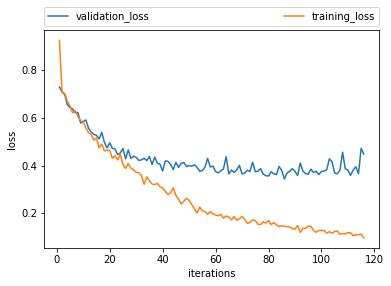

[0.7300998013595055,
 0.7094837838205797,
 0.6978219151496887,
 0.6554016892252297,
 0.6433247656657778,
 0.6378963240261736,
 0.6214274352994459,
 0.6225366674620529,
 0.5790066040795425,
 0.5838230026179346,
 0.5915738097552595,
 0.5565174848868929,
 0.5412922922907204,
 0.5307960756893816,
 0.5270742147133268,
 0.5122552873759434,
 0.5391940916406697,
 0.49751189556615105,
 0.4739925326972172,
 0.49543774127960205,
 0.4720545092533375,
 0.4698529202362587,
 0.44603457533080004,
 0.4526145036878257,
 0.47148386260558817,
 0.4281185320739088,
 0.4658117540951433,
 0.4299842520006772,
 0.4392294277404917,
 0.43409652340001076,
 0.4215930977772022,
 0.4238707320443515,
 0.4305432202487156,
 0.4211677734194131,
 0.4380653572493586,
 0.40401400574322405,
 0.43528742009195787,
 0.40934690319258593,
 0.4054511436100664,
 0.37708416529770555,
 0.4193318285818758,
 0.4179218230319434,
 0.40508926942430695,
 0.3827766986756489,
 0.4136087180211626,
 0.39186038333794165,
 0.4094414459220294,
 0

In [49]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 1, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.897714558839798, validation_error:0.7351032988778476
Best loss improvement from inf to 0.7351032988778476 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7103940677642823, validation_error:0.7155812588231317
Best loss improvement from 0.7351032988778476 to 0.7155812588231317 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6877478015422821, validation_error:0.682341822262468
Best loss improvement from 0.7155812588231317 to 0.682341822262468 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6585237729549408, validation_error:0.6530860970760214
Best loss improvement from 0.682341822262468 to 0.6530860970760214 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6383231115341187, validation_error:0.6327882080242552
Best loss improvement from 0.6530860970760214 to 0.6327882080242552 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.6311753010749817, valid

minibatch:199, epoch:11, iteration:2799, training_error:0.2156261658668518, validation_error:0.40421421260669316
minibatch:249, epoch:11, iteration:2849, training_error:0.21882764205336572, validation_error:0.3886554862918525
Best loss improvement from 0.39804382057025517 to 0.3886554862918525 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error:0.21191604003310205, validation_error:0.40052986813002617
minibatch:89, epoch:12, iteration:2949, training_error:0.193287945240736, validation_error:0.4105865307923021
minibatch:139, epoch:12, iteration:2999, training_error:0.17827742293477059, validation_error:0.4004942821017627
minibatch:189, epoch:12, iteration:3049, training_error:0.18745069026947023, validation_error:0.39864954249612217
minibatch:239, epoch:12, iteration:3099, training_error:0.18705559492111207, validation_error:0.41140408300120257
minibatch:29, epoch:13, iteration:3149, training_error:0.18782296508550644, validation_error:0.38825768643412095
Best loss improv

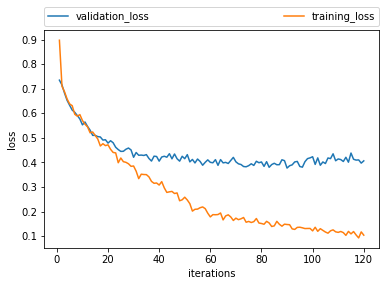

[0.7351032988778476,
 0.7155812588231317,
 0.682341822262468,
 0.6530860970760214,
 0.6327882080242552,
 0.6133755034413831,
 0.604141557011111,
 0.5909060126748579,
 0.5769180963779318,
 0.5531458864951956,
 0.5647653382399986,
 0.5465284257099546,
 0.531435589338171,
 0.5103732645511627,
 0.510276593011001,
 0.50531549494842,
 0.5037491742906899,
 0.49116981337810384,
 0.4925346066211832,
 0.47882766764739465,
 0.4884083805413082,
 0.4802315831184387,
 0.4618819160708066,
 0.45237668321050445,
 0.4450341247279069,
 0.44548602042527036,
 0.4537510409437377,
 0.45872728166909055,
 0.4510229168267086,
 0.42109970697041216,
 0.4405571160645321,
 0.42926031453856106,
 0.4300353917582282,
 0.42850001618779937,
 0.43185744768586654,
 0.4162176600817976,
 0.4057130238105511,
 0.4255707973036273,
 0.42429702908828343,
 0.4052837696568719,
 0.4221683237059363,
 0.42526432409368714,
 0.4213553862325076,
 0.43569411851208784,
 0.4148340631147911,
 0.43450227688098775,
 0.4150689362451948,
 0.405

In [50]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8849938344955445, validation_error:0.717027133908765
Best loss improvement from inf to 0.717027133908765 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7094488000869751, validation_error:0.7031909083497936
Best loss improvement from 0.717027133908765 to 0.7031909083497936 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6852946364879609, validation_error:0.6714261523608503
Best loss improvement from 0.7031909083497936 to 0.6714261523608503 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6787693750858307, validation_error:0.6672190283906871
Best loss improvement from 0.6714261523608503 to 0.6672190283906871 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6626713836193084, validation_error:0.6541881622939274
Best loss improvement from 0.6672190283906871 to 0.6541881622939274 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.6409280633926392, vali

minibatch:169, epoch:11, iteration:2749, training_error:0.2166605092585087, validation_error:0.4463364851885828
minibatch:219, epoch:11, iteration:2799, training_error:0.23127232864499092, validation_error:0.4103369342869726
minibatch:11, epoch:12, iteration:2849, training_error:0.21608908608555794, validation_error:0.3940716087818146
Best loss improvement from 0.3984026821522877 to 0.3940716087818146 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:0.2064786297082901, validation_error:0.39957917918419017
minibatch:111, epoch:12, iteration:2949, training_error:0.18834261417388917, validation_error:0.41331637368119994
minibatch:161, epoch:12, iteration:2999, training_error:0.20108362808823585, validation_error:0.4219596067379261
minibatch:211, epoch:12, iteration:3049, training_error:0.18749560564756393, validation_error:0.44916939118812826
minibatch:3, epoch:13, iteration:3099, training_error:0.20201618641614913, validation_error:0.4114825324765567
minibatch:53, epoch

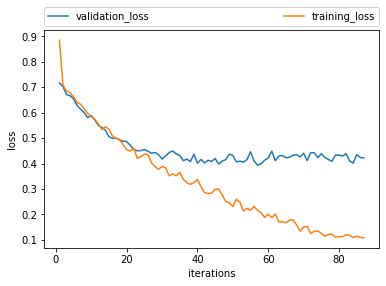

[0.717027133908765,
 0.7031909083497936,
 0.6714261523608503,
 0.6672190283906871,
 0.6541881622939274,
 0.6284688197333237,
 0.6138144813734909,
 0.6005933459462791,
 0.5809525826881672,
 0.5886711005506844,
 0.5716046362087644,
 0.5501554844708278,
 0.5419664465147873,
 0.5312496351784673,
 0.5055452811306921,
 0.49932571423464805,
 0.5011198078763897,
 0.49280858039855957,
 0.48819028200774356,
 0.4866543946595028,
 0.4722584403794387,
 0.4559712656613054,
 0.45044057225358897,
 0.4511617802340409,
 0.45532593439365254,
 0.44863093721455544,
 0.4406099381117985,
 0.4440154936806909,
 0.4356385561926612,
 0.41790823124606036,
 0.43000435007029564,
 0.4431458593442522,
 0.4496085314915098,
 0.4381614337707388,
 0.43199313714586457,
 0.4114003464065749,
 0.4177932076413056,
 0.40771826844790887,
 0.4369111759909268,
 0.40179160802528774,
 0.41648914330992204,
 0.4027961420601812,
 0.4128884056518818,
 0.40877955740895766,
 0.41987422673866664,
 0.3984026821522877,
 0.40973072576111763,

In [51]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8805376493930817, validation_error:0.7356321318396206
Best loss improvement from inf to 0.7356321318396206 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7158042252063751, validation_error:0.7068581293369162
Best loss improvement from 0.7356321318396206 to 0.7068581293369162 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6818689095973969, validation_error:0.6824156230893629
Best loss improvement from 0.7068581293369162 to 0.6824156230893629 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6634417355060578, validation_error:0.6725218337157677
Best loss improvement from 0.6824156230893629 to 0.6725218337157677 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6440497505664825, validation_error:0.6403361168400995
Best loss improvement from 0.6725218337157677 to 0.6403361168400995 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.619136564731598, va

minibatch:249, epoch:11, iteration:2799, training_error:0.21328881099820138, validation_error:0.3863409197536008
minibatch:44, epoch:12, iteration:2849, training_error:0.17782073527574538, validation_error:0.4105114058173936
minibatch:94, epoch:12, iteration:2899, training_error:0.19851560458540918, validation_error:0.3898821493674969
minibatch:144, epoch:12, iteration:2949, training_error:0.19840896658599377, validation_error:0.4073067281780572
minibatch:194, epoch:12, iteration:2999, training_error:0.20233222365379333, validation_error:0.3724481401772335
minibatch:244, epoch:12, iteration:3049, training_error:0.19589697048068047, validation_error:0.37934779812549724
minibatch:39, epoch:13, iteration:3099, training_error:0.17388611570000648, validation_error:0.38848237590543155
Patience ran out at 3099. Finetuning, and improving patience.
minibatch:89, epoch:13, iteration:3149, training_error:0.16037394538521765, validation_error:0.4065339878715318
minibatch:139, epoch:13, iteration:3

minibatch:179, epoch:25, iteration:6299, training_error:0.07602231519296765, validation_error:0.4174520126704512
minibatch:229, epoch:25, iteration:6349, training_error:0.07802053067833185, validation_error:0.37033923792427986
minibatch:24, epoch:26, iteration:6399, training_error:0.0703567473590374, validation_error:0.39187409446157256
minibatch:74, epoch:26, iteration:6449, training_error:0.07652855161577463, validation_error:0.3969363482861683
minibatch:124, epoch:26, iteration:6499, training_error:0.06776966894045472, validation_error:0.4045002835577932
minibatch:174, epoch:26, iteration:6549, training_error:0.07074069045484066, validation_error:0.4279789909206588
minibatch:224, epoch:26, iteration:6599, training_error:0.06750373609364033, validation_error:0.38239780980451354
minibatch:19, epoch:27, iteration:6649, training_error:0.06831166096031666, validation_error:0.4400047665012294
minibatch:69, epoch:27, iteration:6699, training_error:0.0652138358540833, validation_error:0.401

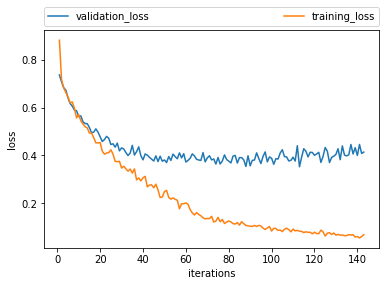

[0.7356321318396206,
 0.7068581293369162,
 0.6824156230893629,
 0.6725218337157677,
 0.6403361168400995,
 0.6167451800971195,
 0.6058642144860893,
 0.5893807308427219,
 0.5864426997201196,
 0.5626867978737272,
 0.5649885381090229,
 0.5401398272349917,
 0.5332028033404514,
 0.5323144115250686,
 0.5163624666888138,
 0.4945488818760576,
 0.4973297057480648,
 0.5109283348609661,
 0.49737937799815474,
 0.47754360992332984,
 0.45814849590433054,
 0.4662971321878762,
 0.4796185051572734,
 0.47191254023847906,
 0.4456973147803339,
 0.4486637670418312,
 0.4346779029944847,
 0.4514183915894607,
 0.4192572194954445,
 0.43152733712360775,
 0.42696846148063394,
 0.41239841642050906,
 0.39955966637052337,
 0.40978376875663625,
 0.44196137374845046,
 0.40158625306754275,
 0.41600591766423195,
 0.43594449758529663,
 0.39885978041024045,
 0.38178333177648743,
 0.40627697110176086,
 0.4014681526299181,
 0.3924922203195506,
 0.384756266043104,
 0.3767851745260173,
 0.398273648886845,
 0.37452283912691575

In [52]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8782332479953766, validation_error:0.7156074356149744
Best loss improvement from inf to 0.7156074356149744 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7063314890861512, validation_error:0.7005964252683852
Best loss improvement from 0.7156074356149744 to 0.7005964252683852 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6896545732021332, validation_error:0.6771224670939975
Best loss improvement from 0.7005964252683852 to 0.6771224670939975 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6598550128936768, validation_error:0.6729741118572377
Best loss improvement from 0.6771224670939975 to 0.6729741118572377 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6510105276107788, validation_error:0.6469578676753573
Best loss improvement from 0.6729741118572377 to 0.6469578676753573 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6349842417240142, val

minibatch:239, epoch:11, iteration:2699, training_error:0.30205611169338226, validation_error:0.4225553064434617
minibatch:43, epoch:12, iteration:2749, training_error:0.3100584262609482, validation_error:0.400969758077904
Best loss improvement from 0.41163592482054673 to 0.400969758077904 in epoch 12
minibatch:93, epoch:12, iteration:2799, training_error:0.30469682544469834, validation_error:0.4061974237362544
minibatch:143, epoch:12, iteration:2849, training_error:0.3107453170418739, validation_error:0.4203277274414345
minibatch:193, epoch:12, iteration:2899, training_error:0.3211126407980919, validation_error:0.4101338243042981
minibatch:243, epoch:12, iteration:2949, training_error:0.3121729511022568, validation_error:0.39473828507794273
Best loss improvement from 0.400969758077904 to 0.39473828507794273 in epoch 12
minibatch:47, epoch:13, iteration:2999, training_error:0.30763806991279125, validation_error:0.41245250514260046
minibatch:97, epoch:13, iteration:3049, training_error:

minibatch:145, epoch:25, iteration:6049, training_error:0.14973651990294456, validation_error:0.3733882186589418
minibatch:195, epoch:25, iteration:6099, training_error:0.16689290791749956, validation_error:0.3826390466204396
minibatch:245, epoch:25, iteration:6149, training_error:0.15580375351011752, validation_error:0.40069493154684704
minibatch:49, epoch:26, iteration:6199, training_error:0.14430448785424232, validation_error:0.37758614122867584
minibatch:99, epoch:26, iteration:6249, training_error:0.16002571165561677, validation_error:0.3707434082472766
minibatch:149, epoch:26, iteration:6299, training_error:0.16862322196364402, validation_error:0.37819685924936225
minibatch:199, epoch:26, iteration:6349, training_error:0.14698058150708676, validation_error:0.38310500813855064
minibatch:3, epoch:27, iteration:6399, training_error:0.15836489848792554, validation_error:0.37611294510187926
minibatch:53, epoch:27, iteration:6449, training_error:0.1432272145152092, validation_error:0.3

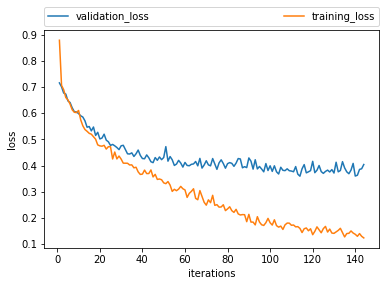

[0.7156074356149744,
 0.7005964252683852,
 0.6771224670939975,
 0.6729741118572377,
 0.6469578676753573,
 0.6409055127037896,
 0.6207434225965429,
 0.6058377491103278,
 0.6049881687870732,
 0.5987673501173655,
 0.5903159843550788,
 0.5853947158213015,
 0.5710197433277413,
 0.5466597146458096,
 0.5493452173692209,
 0.5328477874950126,
 0.547468650120276,
 0.5152654460182896,
 0.5272775170979677,
 0.5020667148960961,
 0.5053227102314984,
 0.5201331928924278,
 0.49744294197471056,
 0.49119489833160684,
 0.4773186875714196,
 0.48113919849748965,
 0.4757150643401676,
 0.4693761677653701,
 0.46130468558382104,
 0.47589004702038235,
 0.47777602738804287,
 0.4618126628575502,
 0.44531486873273496,
 0.44453064379868684,
 0.44894243280092877,
 0.4352055225107405,
 0.4454941826838034,
 0.45961877703666687,
 0.4393608084431401,
 0.4272909131315019,
 0.42648967383084474,
 0.441086177472715,
 0.43014497999791745,
 0.41510882863291987,
 0.41163592482054673,
 0.4309971707838553,
 0.4206044982980799,
 

In [53]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 0, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.873957153558731, validation_error:0.7205996677793306
Best loss improvement from inf to 0.7205996677793306 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7124387180805206, validation_error:0.7113893710333725
Best loss improvement from 0.7205996677793306 to 0.7113893710333725 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6838670241832733, validation_error:0.6825207821254072
Best loss improvement from 0.7113893710333725 to 0.6825207821254072 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6697902941703796, validation_error:0.669454393715694
Best loss improvement from 0.6825207821254072 to 0.669454393715694 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6559825110435485, validation_error:0.6514182686805725
Best loss improvement from 0.669454393715694 to 0.6514182686805725 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6350219988822937, valid

minibatch:77, epoch:12, iteration:2849, training_error:0.2876737603545189, validation_error:0.4005096215626289
minibatch:127, epoch:12, iteration:2899, training_error:0.3133347737789154, validation_error:0.38687244777021734
minibatch:177, epoch:12, iteration:2949, training_error:0.3135149711370468, validation_error:0.3779511158836299
minibatch:227, epoch:12, iteration:2999, training_error:0.3061563166975975, validation_error:0.38405384791308433
minibatch:25, epoch:13, iteration:3049, training_error:0.2926226380467415, validation_error:0.39160467412900823
minibatch:75, epoch:13, iteration:3099, training_error:0.27493211448192595, validation_error:0.3962058512301281
minibatch:125, epoch:13, iteration:3149, training_error:0.2973957559466362, validation_error:0.4490400542472971
minibatch:175, epoch:13, iteration:3199, training_error:0.2919748741388321, validation_error:0.40872814480600683
minibatch:225, epoch:13, iteration:3249, training_error:0.28210640877485277, validation_error:0.378449

minibatch:201, epoch:25, iteration:6249, training_error:0.1706541334092617, validation_error:0.3338824364131895
minibatch:251, epoch:25, iteration:6299, training_error:0.16413178145885468, validation_error:0.3496300423967427
minibatch:49, epoch:26, iteration:6349, training_error:0.17967160776257515, validation_error:0.3309499087004826
minibatch:99, epoch:26, iteration:6399, training_error:0.14447203554213048, validation_error:0.37265848342714636
minibatch:149, epoch:26, iteration:6449, training_error:0.18031042739748954, validation_error:0.33796682953834534
minibatch:199, epoch:26, iteration:6499, training_error:0.16347064927220345, validation_error:0.35981347437562616
minibatch:249, epoch:26, iteration:6549, training_error:0.15245757766067983, validation_error:0.3385295482545063
minibatch:47, epoch:27, iteration:6599, training_error:0.13376488097012043, validation_error:0.39766989442808875
minibatch:97, epoch:27, iteration:6649, training_error:0.15964151680469513, validation_error:0.3

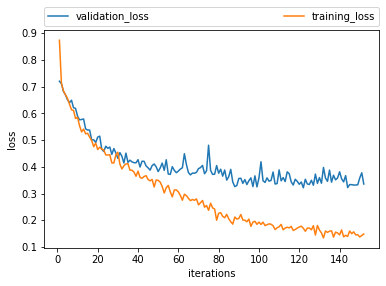

[0.7205996677793306,
 0.7113893710333725,
 0.6825207821254072,
 0.669454393715694,
 0.6514182686805725,
 0.6403598980656986,
 0.6492464069662423,
 0.621190575690105,
 0.6188953827167379,
 0.5896486485826558,
 0.5759590925841496,
 0.5772601273553125,
 0.5790895521640778,
 0.5418447533558155,
 0.5378608374760069,
 0.537502653639892,
 0.5006569695883784,
 0.5012018844999117,
 0.4909593740413929,
 0.5112321993400311,
 0.514804838032558,
 0.46611492181646413,
 0.4573113168108052,
 0.4771879407866248,
 0.46932692877177534,
 0.47399957837729617,
 0.4465266132149203,
 0.4683610108391992,
 0.45201844079741116,
 0.4318036827547797,
 0.45304481017178505,
 0.43932686900270396,
 0.4141385431947379,
 0.45121531548171206,
 0.41658825555752066,
 0.4248830362640578,
 0.4185666945473901,
 0.41549671929458093,
 0.41498483049458473,
 0.42665171212163466,
 0.3991232170113202,
 0.4210093966845808,
 0.42063652133119517,
 0.4032649603383294,
 0.39603584696506633,
 0.387556674151585,
 0.4045702835609173,
 0.41

In [54]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 1, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.9068491959571838, validation_error:0.7283931189569933
Best loss improvement from inf to 0.7283931189569933 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7093585300445556, validation_error:0.6995313640298515
Best loss improvement from 0.7283931189569933 to 0.6995313640298515 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6841157484054565, validation_error:0.669563655195565
Best loss improvement from 0.6995313640298515 to 0.669563655195565 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6644259583950043, validation_error:0.6442460767154036
Best loss improvement from 0.669563655195565 to 0.6442460767154036 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6474785089492798, validation_error:0.6343578120757793
Best loss improvement from 0.6442460767154036 to 0.6343578120757793 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.632471284866333, valid

minibatch:149, epoch:11, iteration:2749, training_error:0.3243688154220581, validation_error:0.40458195476696407
minibatch:199, epoch:11, iteration:2799, training_error:0.3177382412552834, validation_error:0.41748124104121637
minibatch:249, epoch:11, iteration:2849, training_error:0.3095432370901108, validation_error:0.4067725487824144
minibatch:39, epoch:12, iteration:2899, training_error:0.2875715740025043, validation_error:0.41345385539120644
minibatch:89, epoch:12, iteration:2949, training_error:0.317919143140316, validation_error:0.39745796548909157
minibatch:139, epoch:12, iteration:2999, training_error:0.3169104468822479, validation_error:0.4094314171836294
minibatch:189, epoch:12, iteration:3049, training_error:0.2874039214849472, validation_error:0.3948457497974922
minibatch:239, epoch:12, iteration:3099, training_error:0.3226960673928261, validation_error:0.40142243946420736
minibatch:29, epoch:13, iteration:3149, training_error:0.29460809379816055, validation_error:0.3911690

minibatch:169, epoch:24, iteration:6149, training_error:0.18828975036740303, validation_error:0.3476778094110818
minibatch:219, epoch:24, iteration:6199, training_error:0.1848203134536743, validation_error:0.34103222139950456
minibatch:9, epoch:25, iteration:6249, training_error:0.1876711431145668, validation_error:0.3330875948585313
Best loss improvement from 0.33450073928668583 to 0.3330875948585313 in epoch 25
minibatch:59, epoch:25, iteration:6299, training_error:0.173978001922369, validation_error:0.3519006797979618
minibatch:109, epoch:25, iteration:6349, training_error:0.1836376318335533, validation_error:0.31753319424801857
Best loss improvement from 0.3330875948585313 to 0.31753319424801857 in epoch 25
minibatch:159, epoch:25, iteration:6399, training_error:0.17222935676574708, validation_error:0.34491794016854516
minibatch:209, epoch:25, iteration:6449, training_error:0.17241264574229717, validation_error:0.3486395498801922
minibatch:259, epoch:25, iteration:6499, training_er

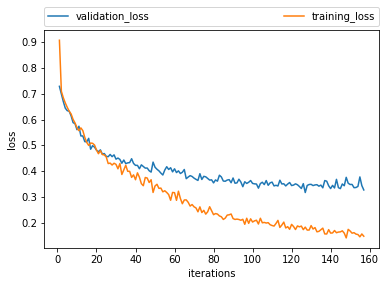

[0.7283931189569933,
 0.6995313640298515,
 0.669563655195565,
 0.6442460767154036,
 0.6343578120757793,
 0.6322924864703211,
 0.6141441711064043,
 0.5881801987516468,
 0.5837442268585337,
 0.5608585754345203,
 0.5740713600454659,
 0.5365241293249459,
 0.5364134733019204,
 0.5145949865209645,
 0.5136575637192562,
 0.5273406721394638,
 0.48515549199334507,
 0.4987997762088118,
 0.4932517481261286,
 0.48160296473009834,
 0.4754035298166604,
 0.4826916065709344,
 0.4660243145350752,
 0.46830467725622243,
 0.4575337839537653,
 0.4561660587787628,
 0.4648798334187475,
 0.45637794609727533,
 0.46327519930642225,
 0.44666908732775984,
 0.4509450741882982,
 0.4456795546515235,
 0.430844535087717,
 0.4433546333477415,
 0.429356599676198,
 0.43235965330025244,
 0.4333962479542042,
 0.44837513360483894,
 0.4301609474009481,
 0.4226065791886428,
 0.4227901553285533,
 0.40953760105988074,
 0.4246321351363741,
 0.4183474095730946,
 0.4120254198025013,
 0.412350229148207,
 0.4019452467046935,
 0.39661

In [55]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 2, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.875158715248108, validation_error:0.7272360180986339
Best loss improvement from inf to 0.7272360180986339 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7181408858299255, validation_error:0.6959176782904
Best loss improvement from 0.7272360180986339 to 0.6959176782904 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6990872895717621, validation_error:0.675453860184242
Best loss improvement from 0.6959176782904 to 0.675453860184242 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6755989301204681, validation_error:0.6753276093252774
Best loss improvement from 0.675453860184242 to 0.6753276093252774 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6723466622829437, validation_error:0.6380431631515766
Best loss improvement from 0.6753276093252774 to 0.6380431631515766 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.6425639271736145, validation_err

minibatch:169, epoch:11, iteration:2749, training_error:0.33355888187885285, validation_error:0.3940681393804221
minibatch:219, epoch:11, iteration:2799, training_error:0.33287553906440737, validation_error:0.4011486218921069
minibatch:11, epoch:12, iteration:2849, training_error:0.31928419560194016, validation_error:0.3824790705894602
Best loss improvement from 0.3871100298289595 to 0.3824790705894602 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:0.305213882625103, validation_error:0.40501663602631666
minibatch:111, epoch:12, iteration:2949, training_error:0.30821754068136215, validation_error:0.41875206602030784
minibatch:161, epoch:12, iteration:2999, training_error:0.3245164632797241, validation_error:0.4114294935917032
minibatch:211, epoch:12, iteration:3049, training_error:0.31441260427236556, validation_error:0.40521118712836296
minibatch:3, epoch:13, iteration:3099, training_error:0.311954899430275, validation_error:0.41075720458195125
minibatch:53, epoch:1

minibatch:115, epoch:24, iteration:6049, training_error:0.16482554569840432, validation_error:0.35142292596142866
minibatch:165, epoch:24, iteration:6099, training_error:0.171512703448534, validation_error:0.3648992735764076
minibatch:215, epoch:24, iteration:6149, training_error:0.17240915462374687, validation_error:0.36883283894637536
minibatch:7, epoch:25, iteration:6199, training_error:0.15938132537761704, validation_error:0.38316642056251393
minibatch:57, epoch:25, iteration:6249, training_error:0.158569425791502, validation_error:0.36391190413771
minibatch:107, epoch:25, iteration:6299, training_error:0.16406158648431302, validation_error:0.36600715949617585
minibatch:157, epoch:25, iteration:6349, training_error:0.17006765872240068, validation_error:0.36934658371168994
minibatch:207, epoch:25, iteration:6399, training_error:0.16263408631086348, validation_error:0.3665703211365075
minibatch:257, epoch:25, iteration:6449, training_error:0.16980849973857404, validation_error:0.3755

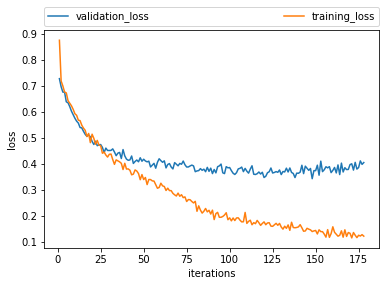

[0.7272360180986339,
 0.6959176782904,
 0.675453860184242,
 0.6753276093252774,
 0.6380431631515766,
 0.6344156511898699,
 0.6196897790349764,
 0.6020728647708893,
 0.58840100621355,
 0.5749058836492998,
 0.5635562056097491,
 0.5562811339723652,
 0.5391054112335731,
 0.5375382879684711,
 0.524378783743957,
 0.5128530993543822,
 0.5050984230534784,
 0.5106335991415484,
 0.5032290775200416,
 0.4857317178413786,
 0.4736524820327759,
 0.4861972475874013,
 0.4691269438842247,
 0.47231885996358147,
 0.4734024929589239,
 0.46247144608662044,
 0.44231458573505794,
 0.4598812409516039,
 0.45068904397816495,
 0.45061502785518254,
 0.4509799624311513,
 0.4568129911504943,
 0.44488749216342793,
 0.43056192377517966,
 0.44041866783438055,
 0.44313682564373674,
 0.41973015049408224,
 0.45416008090150767,
 0.42989893052084693,
 0.4174376140380728,
 0.4129597904353306,
 0.4142369093566105,
 0.4293609497876003,
 0.40080075325637027,
 0.40820642586412104,
 0.41393893083621713,
 0.40711972631257154,
 0.4

In [56]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 3, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.9252648901939392, validation_error:0.713501473952984
Best loss improvement from inf to 0.713501473952984 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7015858447551727, validation_error:0.6864450553367878
Best loss improvement from 0.713501473952984 to 0.6864450553367878 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6828228771686554, validation_error:0.6753620875292811
Best loss improvement from 0.6864450553367878 to 0.6753620875292811 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.667142767906189, validation_error:0.6590507338786947
Best loss improvement from 0.6753620875292811 to 0.6590507338786947 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6546302974224091, validation_error:0.636407850117519
Best loss improvement from 0.6590507338786947 to 0.636407850117519 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6319632422924042, validat

minibatch:149, epoch:11, iteration:2699, training_error:0.3109140220284462, validation_error:0.384675361986818
minibatch:199, epoch:11, iteration:2749, training_error:0.29680271983146667, validation_error:0.39134103162535305
minibatch:249, epoch:11, iteration:2799, training_error:0.3102242848277092, validation_error:0.3816238312885679
minibatch:44, epoch:12, iteration:2849, training_error:0.29339610248804093, validation_error:0.3966975910910245
minibatch:94, epoch:12, iteration:2899, training_error:0.30162240386009215, validation_error:0.3916456149569873
minibatch:144, epoch:12, iteration:2949, training_error:0.28947794795036313, validation_error:0.3921958685948931
minibatch:194, epoch:12, iteration:2999, training_error:0.2792799982428551, validation_error:0.363056271240629
Best loss improvement from 0.3798695196365488 to 0.363056271240629 in epoch 12
minibatch:244, epoch:12, iteration:3049, training_error:0.2977498909831047, validation_error:0.37084672934022445
minibatch:39, epoch:13,

minibatch:184, epoch:24, iteration:6049, training_error:0.15141699805855752, validation_error:0.35711473534847127
minibatch:234, epoch:24, iteration:6099, training_error:0.15252809546887874, validation_error:0.3148231043897826
minibatch:29, epoch:25, iteration:6149, training_error:0.15857586354017258, validation_error:0.33288069557527017
minibatch:79, epoch:25, iteration:6199, training_error:0.1412227964401245, validation_error:0.3223540186882019
minibatch:129, epoch:25, iteration:6249, training_error:0.14046249084174633, validation_error:0.3561891368750868
minibatch:179, epoch:25, iteration:6299, training_error:0.1495099975168705, validation_error:0.34296490714467803
Patience ran out at 6299. Ending training


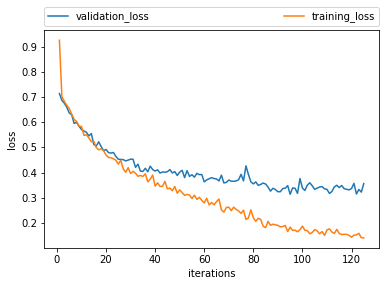

[0.713501473952984,
 0.6864450553367878,
 0.6753620875292811,
 0.6590507338786947,
 0.636407850117519,
 0.6297629105633703,
 0.5950855283901609,
 0.5990804331056003,
 0.5836703294310076,
 0.5708316482346634,
 0.5646679442504356,
 0.559932788898205,
 0.5453319806477119,
 0.5549460258977167,
 0.5117599964141846,
 0.5046343125146011,
 0.5221093327834688,
 0.5032419562339783,
 0.48707263120289507,
 0.49143935688610735,
 0.47921950960981435,
 0.47715634518656236,
 0.47973059888543756,
 0.464095754870053,
 0.45283529573473436,
 0.4521382574377389,
 0.45128164003635274,
 0.4463034035830662,
 0.4493062588675269,
 0.45309946454804517,
 0.4526933750201916,
 0.4207574344914535,
 0.4331891290072737,
 0.4055444413218005,
 0.4043777631274585,
 0.416896424416838,
 0.4029333719919468,
 0.42530091261041575,
 0.4116325070118082,
 0.40605879292405883,
 0.41072662123318376,
 0.39803965954945003,
 0.40225419607655755,
 0.40125155603063517,
 0.4034079082053283,
 0.41153148022191277,
 0.3984148682191454,
 0.

In [57]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 4, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8856762373447418, validation_error:0.7207636722811946
Best loss improvement from inf to 0.7207636722811946 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7218575811386109, validation_error:0.7056612372398376
Best loss improvement from 0.7207636722811946 to 0.7056612372398376 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.689272483587265, validation_error:0.6806830520983096
Best loss improvement from 0.7056612372398376 to 0.6806830520983096 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6775643038749695, validation_error:0.6667603121863471
Best loss improvement from 0.6806830520983096 to 0.6667603121863471 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6511297893524169, validation_error:0.6604583484155161
Best loss improvement from 0.6667603121863471 to 0.6604583484155161 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6462511610984802, vali

minibatch:93, epoch:12, iteration:2799, training_error:0.36946887493133546, validation_error:0.41253771826072977
Best loss improvement from 0.4191948142316606 to 0.41253771826072977 in epoch 12
minibatch:143, epoch:12, iteration:2849, training_error:0.40791574895381927, validation_error:0.4197024780291098
minibatch:193, epoch:12, iteration:2899, training_error:0.39593755185604096, validation_error:0.4096481137805515
Best loss improvement from 0.41253771826072977 to 0.4096481137805515 in epoch 12
minibatch:243, epoch:12, iteration:2949, training_error:0.40537518978118897, validation_error:0.4212859935230679
minibatch:47, epoch:13, iteration:2999, training_error:0.40684505939483645, validation_error:0.4245410285614155
minibatch:97, epoch:13, iteration:3049, training_error:0.3876450663805008, validation_error:0.40642424755626255
Best loss improvement from 0.4096481137805515 to 0.40642424755626255 in epoch 13
minibatch:147, epoch:13, iteration:3099, training_error:0.38756333440542223, vali

minibatch:141, epoch:24, iteration:5799, training_error:0.2890594539046287, validation_error:0.33202605335800733
Best loss improvement from 0.34087026505558576 to 0.33202605335800733 in epoch 24
minibatch:191, epoch:24, iteration:5849, training_error:0.27535873383283616, validation_error:0.35596307670628585
minibatch:241, epoch:24, iteration:5899, training_error:0.2689280650019646, validation_error:0.34535714597613726
minibatch:45, epoch:25, iteration:5949, training_error:0.2964222115278244, validation_error:0.3264821734693315
Best loss improvement from 0.33202605335800733 to 0.3264821734693315 in epoch 25
minibatch:95, epoch:25, iteration:5999, training_error:0.2641965407133102, validation_error:0.33884707976270606
minibatch:145, epoch:25, iteration:6049, training_error:0.27751685559749606, validation_error:0.3395455363723967
minibatch:195, epoch:25, iteration:6099, training_error:0.2811470444500446, validation_error:0.33882105736820783
minibatch:245, epoch:25, iteration:6149, trainin

minibatch:97, epoch:38, iteration:9199, training_error:0.22817318096756936, validation_error:0.33507584394128237
minibatch:147, epoch:38, iteration:9249, training_error:0.2557377368211746, validation_error:0.31509708971888933
minibatch:197, epoch:38, iteration:9299, training_error:0.22604578197002412, validation_error:0.327932709897006
minibatch:1, epoch:39, iteration:9349, training_error:0.23815277934074403, validation_error:0.32003082555753215
minibatch:51, epoch:39, iteration:9399, training_error:0.22818315908312797, validation_error:0.32391597854870335
minibatch:101, epoch:39, iteration:9449, training_error:0.2419615362584591, validation_error:0.29261461590175275
Best loss improvement from 0.30022633020524625 to 0.29261461590175275 in epoch 39
minibatch:151, epoch:39, iteration:9499, training_error:0.22259480953216554, validation_error:0.315610745438823
minibatch:201, epoch:39, iteration:9549, training_error:0.21939040675759316, validation_error:0.3166997763845656
minibatch:5, epoc

minibatch:203, epoch:52, iteration:12749, training_error:0.19990930318832398, validation_error:0.28715563703466346
minibatch:7, epoch:53, iteration:12799, training_error:0.20998322777450085, validation_error:0.2736090314057138
Best loss improvement from 0.28483793415405134 to 0.2736090314057138 in epoch 53
minibatch:57, epoch:53, iteration:12849, training_error:0.20288161620497702, validation_error:0.28028812756141025
minibatch:107, epoch:53, iteration:12899, training_error:0.21211037933826446, validation_error:0.30936325782978974
minibatch:157, epoch:53, iteration:12949, training_error:0.19098296716809274, validation_error:0.29682189584882174
minibatch:207, epoch:53, iteration:12999, training_error:0.20881257511675358, validation_error:0.28156402789884144
minibatch:11, epoch:54, iteration:13049, training_error:0.1957122928649187, validation_error:0.28271353355160467
minibatch:61, epoch:54, iteration:13099, training_error:0.19545830488204957, validation_error:0.2791619935521373
minibat

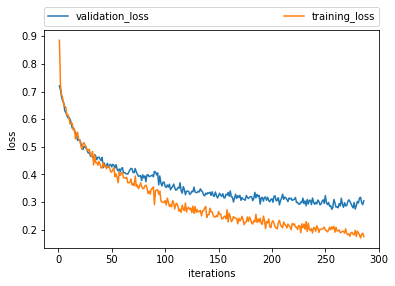

[0.7207636722811946,
 0.7056612372398376,
 0.6806830520983096,
 0.6667603121863471,
 0.6604583484155161,
 0.6303363309966193,
 0.6240652071105109,
 0.6125146371346933,
 0.6054931305072926,
 0.6069164298198841,
 0.5985628178826085,
 0.5874068416931011,
 0.5672901813630704,
 0.569331991451758,
 0.5601345576621868,
 0.5501106271037349,
 0.5451625773200283,
 0.5230246804378651,
 0.5260551638073392,
 0.5245445160954086,
 0.5151208076212141,
 0.49866402369958385,
 0.4902274862483696,
 0.5011769544195246,
 0.4992300834920671,
 0.49470372442845945,
 0.48649508423275417,
 0.4773691373842734,
 0.4803156057993571,
 0.4666585999506491,
 0.46473187097796687,
 0.46513090641410265,
 0.4569851557413737,
 0.47269350731814347,
 0.4658796411973459,
 0.4535914924409654,
 0.4613344426508303,
 0.4628172218799591,
 0.4567007996417858,
 0.45016376453417317,
 0.4616053843939746,
 0.42432020880557875,
 0.44104479087723625,
 0.4287769275682944,
 0.4307077549121998,
 0.4405174156030019,
 0.42584085795614457,
 0.4

In [58]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 0, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.88673743724823, validation_error:0.7223992943763733
Best loss improvement from inf to 0.7223992943763733 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7165300250053406, validation_error:0.71034509149091
Best loss improvement from 0.7223992943763733 to 0.71034509149091 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6877753567695618, validation_error:0.7070339568730059
Best loss improvement from 0.71034509149091 to 0.7070339568730059 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6688449823856354, validation_error:0.6824424431241792
Best loss improvement from 0.7070339568730059 to 0.6824424431241792 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6493448734283447, validation_error:0.6643836724347082
Best loss improvement from 0.6824424431241792 to 0.6643836724347082 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6517637026309967, validatio

minibatch:27, epoch:12, iteration:2799, training_error:0.3860116583108902, validation_error:0.4025730141277971
minibatch:77, epoch:12, iteration:2849, training_error:0.37593211472034455, validation_error:0.3898340795060684
Best loss improvement from 0.39281816831950483 to 0.3898340795060684 in epoch 12
minibatch:127, epoch:12, iteration:2899, training_error:0.38151635706424714, validation_error:0.3853090279575052
Best loss improvement from 0.3898340795060684 to 0.3853090279575052 in epoch 12
minibatch:177, epoch:12, iteration:2949, training_error:0.40065226137638094, validation_error:0.39707317023441707
minibatch:227, epoch:12, iteration:2999, training_error:0.40168442666530607, validation_error:0.40207096626018657
minibatch:25, epoch:13, iteration:3049, training_error:0.3803233930468559, validation_error:0.40142569048651333
minibatch:75, epoch:13, iteration:3099, training_error:0.36270514637231827, validation_error:0.37639829053961
Best loss improvement from 0.3853090279575052 to 0.37

minibatch:53, epoch:24, iteration:5849, training_error:0.28472703486680984, validation_error:0.310369074344635
minibatch:103, epoch:24, iteration:5899, training_error:0.2846962103247643, validation_error:0.3529596351857843
minibatch:153, epoch:24, iteration:5949, training_error:0.2786073389649391, validation_error:0.30547355115413666
minibatch:203, epoch:24, iteration:5999, training_error:0.2680625319480896, validation_error:0.3236513703033842
minibatch:1, epoch:25, iteration:6049, training_error:0.2918341940641403, validation_error:0.3136312658416814
minibatch:51, epoch:25, iteration:6099, training_error:0.29349612891674043, validation_error:0.2982270974537422
Best loss improvement from 0.2993548014040651 to 0.2982270974537422 in epoch 25
minibatch:101, epoch:25, iteration:6149, training_error:0.2857920032739639, validation_error:0.3047162862173442
minibatch:151, epoch:25, iteration:6199, training_error:0.27030149757862093, validation_error:0.29900883831854524
minibatch:201, epoch:25,

minibatch:229, epoch:36, iteration:9049, training_error:0.23103922754526138, validation_error:0.27418273019379585
minibatch:27, epoch:37, iteration:9099, training_error:0.22567177042365075, validation_error:0.2735605018919912
minibatch:77, epoch:37, iteration:9149, training_error:0.24001894757151604, validation_error:0.3105652419657543
minibatch:127, epoch:37, iteration:9199, training_error:0.23596611529588699, validation_error:0.2829552986498537
minibatch:177, epoch:37, iteration:9249, training_error:0.2620010244846344, validation_error:0.2732481700849944
minibatch:227, epoch:37, iteration:9299, training_error:0.2424958539009094, validation_error:0.27201881901971225
minibatch:25, epoch:38, iteration:9349, training_error:0.24490297928452492, validation_error:0.2766710568604798
minibatch:75, epoch:38, iteration:9399, training_error:0.22459333151578903, validation_error:0.2660756316678277
Best loss improvement from 0.26643796265125275 to 0.2660756316678277 in epoch 38
minibatch:125, epoc

minibatch:151, epoch:50, iteration:12499, training_error:0.20422965988516809, validation_error:0.2581209571197115
minibatch:201, epoch:50, iteration:12549, training_error:0.19895378559827803, validation_error:0.2604435579530124
minibatch:251, epoch:50, iteration:12599, training_error:0.204980246424675, validation_error:0.261530814242774
minibatch:49, epoch:51, iteration:12649, training_error:0.21524902552366257, validation_error:0.25241169683506776
minibatch:99, epoch:51, iteration:12699, training_error:0.19477836698293685, validation_error:0.2564080262492443
minibatch:149, epoch:51, iteration:12749, training_error:0.21516448214650155, validation_error:0.2611336160836549
minibatch:199, epoch:51, iteration:12799, training_error:0.18728666946291925, validation_error:0.27897903477323466
minibatch:249, epoch:51, iteration:12849, training_error:0.20746526703238488, validation_error:0.2534296215865119
minibatch:47, epoch:52, iteration:12899, training_error:0.1971989907324314, validation_erro

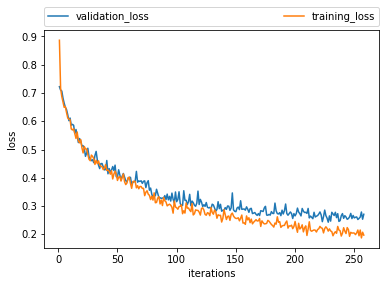

[0.7223992943763733,
 0.71034509149091,
 0.7070339568730059,
 0.6824424431241792,
 0.6643836724347082,
 0.6497230324251898,
 0.641386145147784,
 0.6238319565509928,
 0.6021973449608375,
 0.6114147326041912,
 0.5861125804226974,
 0.5890863373361784,
 0.5858808180381512,
 0.556554181822415,
 0.5709194057974322,
 0.549296228022411,
 0.5246831415028408,
 0.5389178066418089,
 0.5303882905121508,
 0.5125246387103508,
 0.5133957585384106,
 0.5049395859241486,
 0.475930531477106,
 0.487597590890424,
 0.5047239157660254,
 0.4739438408407672,
 0.4674200713634491,
 0.4604642113734936,
 0.4639845346582347,
 0.453494874053988,
 0.4792298273793582,
 0.4934260208031227,
 0.46369631228775815,
 0.4447735743276004,
 0.4326036562179697,
 0.4501323103904724,
 0.4505797902057911,
 0.4386042222894471,
 0.42806394655129004,
 0.4292803879441886,
 0.46124526755563144,
 0.4141592167574784,
 0.43262494021448594,
 0.4214603479566245,
 0.4272538793498072,
 0.43986860020407315,
 0.4254544706180178,
 0.4448808955735

In [59]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 1, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.9083098959922791, validation_error:0.7340387003175144
Best loss improvement from inf to 0.7340387003175144 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7154722833633422, validation_error:0.6915572388418789
Best loss improvement from 0.7340387003175144 to 0.6915572388418789 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.69379638671875, validation_error:0.6628401731622631
Best loss improvement from 0.6915572388418789 to 0.6628401731622631 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6702843940258026, validation_error:0.6709736338977156
minibatch:249, epoch:1, iteration:249, training_error:0.6585099470615386, validation_error:0.6335040392546818
Best loss improvement from 0.6628401731622631 to 0.6335040392546818 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.6406088721752167, validation_error:0.6236736116738155
Best loss improvement from 0.6335040392546818 

minibatch:49, epoch:11, iteration:2649, training_error:0.3995021504163742, validation_error:0.4238480298683561
minibatch:99, epoch:11, iteration:2699, training_error:0.42034357726573945, validation_error:0.4267706444551205
minibatch:149, epoch:11, iteration:2749, training_error:0.40003065407276156, validation_error:0.4094110131263733
Best loss improvement from 0.4205174559149249 to 0.4094110131263733 in epoch 11
minibatch:199, epoch:11, iteration:2799, training_error:0.39346306681633, validation_error:0.4022920378323259
Best loss improvement from 0.4094110131263733 to 0.4022920378323259 in epoch 11
minibatch:249, epoch:11, iteration:2849, training_error:0.3882157099246979, validation_error:0.40166307523332795
Best loss improvement from 0.4022920378323259 to 0.40166307523332795 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error:0.41177010953426363, validation_error:0.40328120928386163
minibatch:89, epoch:12, iteration:2949, training_error:0.40172687351703645, validation_

minibatch:79, epoch:23, iteration:5799, training_error:0.2799613571166992, validation_error:0.33184814504508314
minibatch:129, epoch:23, iteration:5849, training_error:0.27905007570981977, validation_error:0.33304451303235416
minibatch:179, epoch:23, iteration:5899, training_error:0.274718864262104, validation_error:0.34290551625449084
minibatch:229, epoch:23, iteration:5949, training_error:0.2747353634238243, validation_error:0.3349935648770168
minibatch:19, epoch:24, iteration:5999, training_error:0.26150124162435534, validation_error:0.3304404827027485
minibatch:69, epoch:24, iteration:6049, training_error:0.2832739785313606, validation_error:0.3406599811438856
minibatch:119, epoch:24, iteration:6099, training_error:0.2684580731391907, validation_error:0.3315970414671405
minibatch:169, epoch:24, iteration:6149, training_error:0.28237934976816176, validation_error:0.3351691164847078
minibatch:219, epoch:24, iteration:6199, training_error:0.28203494757413866, validation_error:0.328326

minibatch:99, epoch:36, iteration:9199, training_error:0.23803923442959785, validation_error:0.29286021045569716
Best loss improvement from 0.2953588880341628 to 0.29286021045569716 in epoch 36
minibatch:149, epoch:36, iteration:9249, training_error:0.2493070751428604, validation_error:0.30780173786755266
minibatch:199, epoch:36, iteration:9299, training_error:0.2326776123046875, validation_error:0.310534225969479
minibatch:249, epoch:36, iteration:9349, training_error:0.21926991298794746, validation_error:0.31038800960984725
minibatch:39, epoch:37, iteration:9399, training_error:0.21413951739668846, validation_error:0.3082767907401611
minibatch:89, epoch:37, iteration:9449, training_error:0.24206188082695007, validation_error:0.29910381343857995
minibatch:139, epoch:37, iteration:9499, training_error:0.2391783943772316, validation_error:0.3068096149584343
minibatch:189, epoch:37, iteration:9549, training_error:0.2242203536629677, validation_error:0.3179175679025979
minibatch:239, epoc

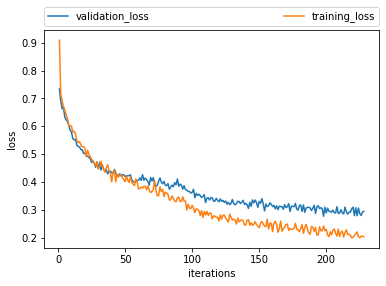

[0.7340387003175144,
 0.6915572388418789,
 0.6628401731622631,
 0.6709736338977156,
 0.6335040392546818,
 0.6236736116738155,
 0.6176844383108204,
 0.6037765104195167,
 0.5865900043783516,
 0.5799071912107796,
 0.5560293629251677,
 0.551504700348295,
 0.5541931791552182,
 0.5331987430309427,
 0.5281069463696973,
 0.5265359899093365,
 0.5170030151975566,
 0.5168339836186376,
 0.503191469044521,
 0.5042911305509764,
 0.4943051738985654,
 0.49392763499555914,
 0.48947806502210683,
 0.4847356450968775,
 0.4708906977341093,
 0.47657209634780884,
 0.46878844191288127,
 0.45387206611962155,
 0.47259619009905846,
 0.4491332491924023,
 0.47054357569793176,
 0.4435269770951107,
 0.4629515388916279,
 0.4446613531688164,
 0.442074762336139,
 0.445118291110828,
 0.429966492899533,
 0.4394112609583756,
 0.4398235164839646,
 0.43471494419821377,
 0.4334349200643342,
 0.44552770873595926,
 0.43320744715887927,
 0.4243554925096446,
 0.4239647748141453,
 0.4304777568784253,
 0.4224203444760421,
 0.42740

In [60]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 2, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8678486406803131, validation_error:0.7299137999271524
Best loss improvement from inf to 0.7299137999271524 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7071317827701569, validation_error:0.7077408453513836
Best loss improvement from 0.7299137999271524 to 0.7077408453513836 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.69674840092659, validation_error:0.6836992440552547
Best loss improvement from 0.7077408453513836 to 0.6836992440552547 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6885988128185272, validation_error:0.651658545280325
Best loss improvement from 0.6836992440552547 to 0.651658545280325 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6650798201560975, validation_error:0.6462039022610105
Best loss improvement from 0.651658545280325 to 0.6462039022610105 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.6702674078941345, valida

minibatch:169, epoch:11, iteration:2749, training_error:0.39834692716598513, validation_error:0.4214739306219693
minibatch:219, epoch:11, iteration:2799, training_error:0.3880562788248062, validation_error:0.41035808468687124
minibatch:11, epoch:12, iteration:2849, training_error:0.3963907864689827, validation_error:0.413969447900509
minibatch:61, epoch:12, iteration:2899, training_error:0.4019264125823975, validation_error:0.40629288245891704
minibatch:111, epoch:12, iteration:2949, training_error:0.41285106509923936, validation_error:0.40943605170167724
minibatch:161, epoch:12, iteration:2999, training_error:0.3910795772075653, validation_error:0.4077248830219795
minibatch:211, epoch:12, iteration:3049, training_error:0.3857061421871185, validation_error:0.4054340935986617
minibatch:3, epoch:13, iteration:3099, training_error:0.39385161936283114, validation_error:0.40180026405844194
minibatch:53, epoch:13, iteration:3149, training_error:0.3711716005206108, validation_error:0.39391895

minibatch:15, epoch:24, iteration:5949, training_error:0.284219718053937, validation_error:0.3415068429091881
minibatch:65, epoch:24, iteration:5999, training_error:0.30160573244094846, validation_error:0.3417413450520614
minibatch:115, epoch:24, iteration:6049, training_error:0.28737752258777616, validation_error:0.35650974357950277
minibatch:165, epoch:24, iteration:6099, training_error:0.27777034789323807, validation_error:0.33365449617648946
minibatch:215, epoch:24, iteration:6149, training_error:0.2655060887336731, validation_error:0.32825413294907274
Best loss improvement from 0.33148332762307137 to 0.32825413294907274 in epoch 24
minibatch:7, epoch:25, iteration:6199, training_error:0.2754391822218895, validation_error:0.3329659911065266
minibatch:57, epoch:25, iteration:6249, training_error:0.27391107589006425, validation_error:0.3375456214978777
minibatch:107, epoch:25, iteration:6299, training_error:0.27948690682649613, validation_error:0.3185590960342309
Best loss improvemen

minibatch:61, epoch:37, iteration:9349, training_error:0.22060423836112023, validation_error:0.31955459123027735
minibatch:111, epoch:37, iteration:9399, training_error:0.21391390308737754, validation_error:0.33506385159903557
minibatch:161, epoch:37, iteration:9449, training_error:0.2157164929807186, validation_error:0.3249366684206601
minibatch:211, epoch:37, iteration:9499, training_error:0.25464707404375075, validation_error:0.31737884313895787
minibatch:3, epoch:38, iteration:9549, training_error:0.22904618948698044, validation_error:0.306480387161518
Best loss improvement from 0.3070968348404457 to 0.306480387161518 in epoch 38
minibatch:53, epoch:38, iteration:9599, training_error:0.232970479875803, validation_error:0.3064324624579528
Best loss improvement from 0.306480387161518 to 0.3064324624579528 in epoch 38
minibatch:103, epoch:38, iteration:9649, training_error:0.21526412650942803, validation_error:0.31712842629901294
minibatch:153, epoch:38, iteration:9699, training_error

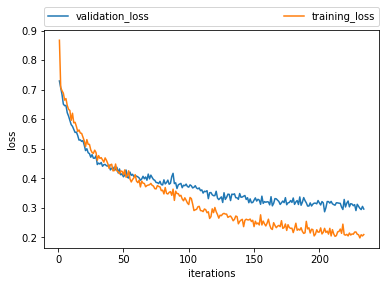

[0.7299137999271524,
 0.7077408453513836,
 0.6836992440552547,
 0.651658545280325,
 0.6462039022610105,
 0.6471406550242983,
 0.622334990008124,
 0.6111303732312959,
 0.5967323995869735,
 0.5820996257765539,
 0.57639338949631,
 0.5657092538373224,
 0.5555695593357086,
 0.556805307495183,
 0.54536215395763,
 0.529771267340101,
 0.5304620903113793,
 0.5253729357801634,
 0.5282078005116562,
 0.5129867874342819,
 0.4942095012500368,
 0.5004191758303806,
 0.48694357481496087,
 0.483819842338562,
 0.4718347870070359,
 0.4804505407810211,
 0.4685504015149741,
 0.46847598408830576,
 0.47652198425654707,
 0.4469949089247605,
 0.4518702893421568,
 0.4486828477218233,
 0.45400475530788814,
 0.4411219646190775,
 0.4463466703891754,
 0.4474036621636358,
 0.4428178462488898,
 0.44178753474663046,
 0.4455980011101427,
 0.42880546121761715,
 0.43420628124269944,
 0.43090636874067373,
 0.43842986328848477,
 0.4289897032852831,
 0.43777576602738477,
 0.41847405762508,
 0.43213031518048256,
 0.4121991745

In [61]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 3, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:0.8777689635753632, validation_error:0.7140673871698051
Best loss improvement from inf to 0.7140673871698051 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7124864065647125, validation_error:0.7087739438846193
Best loss improvement from 0.7140673871698051 to 0.7087739438846193 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6944585347175598, validation_error:0.6828490619001717
Best loss improvement from 0.7087739438846193 to 0.6828490619001717 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6689098823070526, validation_error:0.6635315397690082
Best loss improvement from 0.6828490619001717 to 0.6635315397690082 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6530960941314697, validation_error:0.6514383616118595
Best loss improvement from 0.6635315397690082 to 0.6514383616118595 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6457707583904266, v

minibatch:49, epoch:11, iteration:2599, training_error:0.3929849725961685, validation_error:0.39108441821460066
Best loss improvement from 0.40379135362033186 to 0.39108441821460066 in epoch 11
minibatch:99, epoch:11, iteration:2649, training_error:0.39307251513004304, validation_error:0.4004102174578042
minibatch:149, epoch:11, iteration:2699, training_error:0.3987325233221054, validation_error:0.3818072594445327
Best loss improvement from 0.39108441821460066 to 0.3818072594445327 in epoch 11
minibatch:199, epoch:11, iteration:2749, training_error:0.38258522778749465, validation_error:0.3948802280014959
minibatch:249, epoch:11, iteration:2799, training_error:0.39213600039482116, validation_error:0.38479932731595534
minibatch:44, epoch:12, iteration:2849, training_error:0.3674260613322258, validation_error:0.40544896187453433
minibatch:94, epoch:12, iteration:2899, training_error:0.3826290649175644, validation_error:0.38863506399351977
minibatch:144, epoch:12, iteration:2949, training_

minibatch:189, epoch:23, iteration:5799, training_error:0.2771686141192913, validation_error:0.32888232222918806
minibatch:239, epoch:23, iteration:5849, training_error:0.26814164474606517, validation_error:0.3241223877873914
Best loss improvement from 0.32772252092073706 to 0.3241223877873914 in epoch 23
minibatch:34, epoch:24, iteration:5899, training_error:0.26158826276659963, validation_error:0.3264144957065582
minibatch:84, epoch:24, iteration:5949, training_error:0.2779998683929443, validation_error:0.32798231932623634
minibatch:134, epoch:24, iteration:5999, training_error:0.26793561249971387, validation_error:0.3175460007683984
Best loss improvement from 0.3241223877873914 to 0.3175460007683984 in epoch 24
minibatch:184, epoch:24, iteration:6049, training_error:0.2506117418408394, validation_error:0.31409110591329376
Best loss improvement from 0.3175460007683984 to 0.31409110591329376 in epoch 24
minibatch:234, epoch:24, iteration:6099, training_error:0.24531351208686827, valid

minibatch:229, epoch:35, iteration:8899, training_error:0.21560071736574174, validation_error:0.2810553525542391
minibatch:24, epoch:36, iteration:8949, training_error:0.2147594226896763, validation_error:0.25373375672718573
Best loss improvement from 0.2620361650298382 to 0.25373375672718573 in epoch 36
minibatch:74, epoch:36, iteration:8999, training_error:0.21643815457820892, validation_error:0.275370717048645
minibatch:124, epoch:36, iteration:9049, training_error:0.20426161989569663, validation_error:0.28224608918716165
minibatch:174, epoch:36, iteration:9099, training_error:0.22081792920827867, validation_error:0.2946952422117365
minibatch:224, epoch:36, iteration:9149, training_error:0.20269221141934396, validation_error:0.2745467933087513
minibatch:19, epoch:37, iteration:9199, training_error:0.21537002444267273, validation_error:0.2752335821760112
minibatch:69, epoch:37, iteration:9249, training_error:0.212772518992424, validation_error:0.2844075134088253
minibatch:119, epoch:

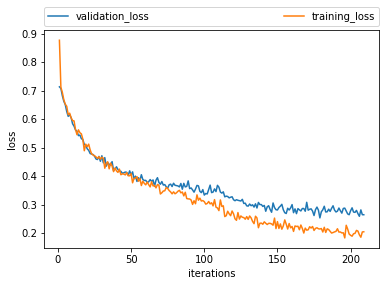

[0.7140673871698051,
 0.7087739438846193,
 0.6828490619001717,
 0.6635315397690082,
 0.6514383616118595,
 0.6275279686368745,
 0.6104541585363191,
 0.616689355208956,
 0.6056819085417122,
 0.5843194589532655,
 0.5760350042376025,
 0.5626871298099386,
 0.5579985657642628,
 0.5427293787742483,
 0.5447151825345796,
 0.5320458771853611,
 0.5288434080008803,
 0.5120166570975863,
 0.50821217380721,
 0.4964686354686474,
 0.49103340198253764,
 0.47986944276711035,
 0.4780758084922001,
 0.47622808916815396,
 0.47046855194815274,
 0.4607430573167472,
 0.4588126653227313,
 0.46957243516527375,
 0.45257660643807773,
 0.4720389061960681,
 0.4471073417828001,
 0.46554266173264075,
 0.4355047036861551,
 0.4478826769467058,
 0.44202376439653596,
 0.4392745916185708,
 0.45140588386305447,
 0.4200852980901455,
 0.42528508243889646,
 0.4333472015528843,
 0.42358435433486413,
 0.4184836375302282,
 0.41743027958376655,
 0.41060186562867,
 0.4121077810895854,
 0.41478938172603474,
 0.4138487824078264,
 0.40

In [62]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)

pretrain_save(model, 'gender', 4, 2, patience=10)

In [63]:
PATH="models/model_celeba_original_network.pt"

model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

#freeze_layer(model.fc1)

#freeze_layer(model.fc2)



print(model)

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


minibatch:49, epoch:1, iteration:49, training_error:3.1770796585083008, validation_error:2.648470456783588
Best loss improvement from inf to 2.648470456783588 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.5235615968704224, validation_error:2.450505100763761
Best loss improvement from 2.648470456783588 to 2.450505100763761 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.4152898025512695, validation_error:2.3428277235764723
Best loss improvement from 2.450505100763761 to 2.3428277235764723 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.3049097204208375, validation_error:2.256957145837637
Best loss improvement from 2.3428277235764723 to 2.256957145837637 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.191293351650238, validation_error:2.199825951686272
Best loss improvement from 2.256957145837637 to 2.199825951686272 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.175208177566528, validation_erro

minibatch:79, epoch:11, iteration:2449, training_error:1.3526611256599426, validation_error:1.5284625750321608
minibatch:129, epoch:11, iteration:2499, training_error:1.3853153038024901, validation_error:1.4831290795252874
Best loss improvement from 1.4967394792116606 to 1.4831290795252874 in epoch 11
minibatch:179, epoch:11, iteration:2549, training_error:1.3809604907035828, validation_error:1.4947150028668916
minibatch:229, epoch:11, iteration:2599, training_error:1.3606836318969726, validation_error:1.4595173872434175
Best loss improvement from 1.4831290795252874 to 1.4595173872434175 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:1.3283988547325134, validation_error:1.4636149223034198
minibatch:92, epoch:12, iteration:2699, training_error:1.3225172209739684, validation_error:1.4655117163291345
minibatch:142, epoch:12, iteration:2749, training_error:1.2878640627861022, validation_error:1.4504553721501277
Best loss improvement from 1.4595173872434175 to 1.45045537

minibatch:185, epoch:23, iteration:5399, training_error:0.7782027411460877, validation_error:1.2668793522394621
minibatch:235, epoch:23, iteration:5449, training_error:0.757954353094101, validation_error:1.3121541463411772
minibatch:48, epoch:24, iteration:5499, training_error:0.7523532187938691, validation_error:1.2997236366455371
minibatch:98, epoch:24, iteration:5549, training_error:0.7621654760837555, validation_error:1.2614302589343145
minibatch:148, epoch:24, iteration:5599, training_error:0.7483506035804749, validation_error:1.288923660149941
minibatch:198, epoch:24, iteration:5649, training_error:0.7631360191106796, validation_error:1.2662750207460844
minibatch:11, epoch:25, iteration:5699, training_error:0.7669813293218612, validation_error:1.26654651761055
minibatch:61, epoch:25, iteration:5749, training_error:0.73252072930336, validation_error:1.2871649196514716
minibatch:111, epoch:25, iteration:5799, training_error:0.729821343421936, validation_error:1.248473467735144
mini

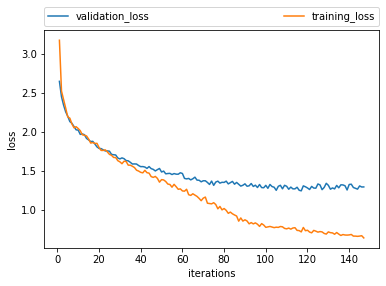

[2.648470456783588,
 2.450505100763761,
 2.3428277235764723,
 2.256957145837637,
 2.199825951686272,
 2.1316148592875552,
 2.1090617730067325,
 2.068421652683845,
 2.0255252581376295,
 2.0216851784632754,
 1.9666447777014513,
 1.972361486691695,
 1.9625237400715168,
 1.9147452436960661,
 1.8958152257479155,
 1.8746267144496624,
 1.8774943397595332,
 1.843551823726067,
 1.8061449344341571,
 1.7866655542300298,
 1.78363141646752,
 1.768973932816432,
 1.7536263053233807,
 1.7539156950437105,
 1.7506035199532142,
 1.709598536674793,
 1.7050302945650542,
 1.7019180059432983,
 1.6634045197413518,
 1.651071773125575,
 1.6645603592579181,
 1.6543714908453135,
 1.6302230312274053,
 1.6266607000277593,
 1.607895200069134,
 1.5857689380645752,
 1.5869328196232135,
 1.5854091506737928,
 1.5661635444714472,
 1.551762553361746,
 1.5528001922827501,
 1.5469292860764723,
 1.529253432383904,
 1.5528564223876367,
 1.5265960372411287,
 1.5170347232085009,
 1.4967394792116606,
 1.5135267055951631,
 1.5284

In [64]:
# Last layer was replaced by a clean layer
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.065115509033203, validation_error:2.5695510650503226
Best loss improvement from inf to 2.5695510650503226 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.4910997772216796, validation_error:2.340262322590269
Best loss improvement from 2.5695510650503226 to 2.340262322590269 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.37195396900177, validation_error:2.256814282515953
Best loss improvement from 2.340262322590269 to 2.256814282515953 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.2013539361953733, validation_error:2.165265572482142
Best loss improvement from 2.256814282515953 to 2.165265572482142 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.0957087755203245, validation_error:2.1119826785449325
Best loss improvement from 2.165265572482142 to 2.1119826785449325 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:2.0968393087387085, validation_er

minibatch:77, epoch:10, iteration:2399, training_error:1.2587287211418152, validation_error:1.4136458840863457
minibatch:127, epoch:10, iteration:2449, training_error:1.2598347163200379, validation_error:1.4086907732075657
minibatch:177, epoch:10, iteration:2499, training_error:1.273119822740555, validation_error:1.3977807266958828
Best loss improvement from 1.3991674308119149 to 1.3977807266958828 in epoch 10
minibatch:227, epoch:10, iteration:2549, training_error:1.219164377450943, validation_error:1.392579904918013
Best loss improvement from 1.3977807266958828 to 1.392579904918013 in epoch 10
minibatch:19, epoch:11, iteration:2599, training_error:1.2326549220085143, validation_error:1.3886889876990482
Best loss improvement from 1.392579904918013 to 1.3886889876990482 in epoch 11
minibatch:69, epoch:11, iteration:2649, training_error:1.2126462292671203, validation_error:1.386670026285895
Best loss improvement from 1.3886889876990482 to 1.386670026285895 in epoch 11
minibatch:119, epo

minibatch:239, epoch:21, iteration:5399, training_error:0.6592537534236907, validation_error:1.2904654412434018
minibatch:31, epoch:22, iteration:5449, training_error:0.6137537866830826, validation_error:1.3088283703244965
Patience ran out at 5449. Finetuning, and improving patience.
minibatch:81, epoch:22, iteration:5499, training_error:0.5726624202728271, validation_error:1.2835047060045703
minibatch:131, epoch:22, iteration:5549, training_error:0.5874829202890396, validation_error:1.254035863383063
minibatch:181, epoch:22, iteration:5599, training_error:0.595715325474739, validation_error:1.2719012622175545
minibatch:231, epoch:22, iteration:5649, training_error:0.5672185093164444, validation_error:1.2414284656787742
minibatch:23, epoch:23, iteration:5699, training_error:0.5709276688098908, validation_error:1.2704392219411915
minibatch:73, epoch:23, iteration:5749, training_error:0.5483158802986146, validation_error:1.2813479139887054
minibatch:123, epoch:23, iteration:5799, trainin

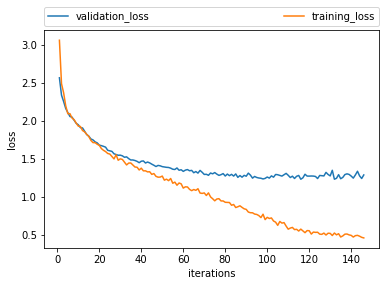

[2.5695510650503226,
 2.340262322590269,
 2.256814282515953,
 2.165265572482142,
 2.1119826785449325,
 2.058939350062403,
 2.0510232243044624,
 2.008814573287964,
 1.968978080256232,
 1.9497699449802268,
 1.9121028924810475,
 1.9083888654051155,
 1.8649925486794834,
 1.821402858043539,
 1.7998968362808228,
 1.762863274278312,
 1.7504127765523976,
 1.7244355884091607,
 1.711446449674409,
 1.6817423351879777,
 1.6744565059398782,
 1.6654806301511567,
 1.6545312199099311,
 1.6134769875427772,
 1.606989626226754,
 1.5991793500966038,
 1.5673000935850472,
 1.556962592848416,
 1.5477307253870471,
 1.5492537309383523,
 1.5402185875793983,
 1.5212568126875778,
 1.5268690051703617,
 1.5033461019910614,
 1.4854891176881462,
 1.4856474605099907,
 1.4783844495641774,
 1.4674019155831173,
 1.4498292659891063,
 1.4691633561561848,
 1.4728879887482216,
 1.445553783712716,
 1.4583022430025299,
 1.447021484375,
 1.4304606051280582,
 1.415890126392759,
 1.3991674308119149,
 1.4136458840863457,
 1.408690

In [65]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 1, 0, patience=10)

In [66]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.0878482103347777, validation_error:2.609310585876991
Best loss improvement from inf to 2.609310585876991 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.4834271478652954, validation_error:2.390952833767595
Best loss improvement from 2.609310585876991 to 2.390952833767595 in epoch 1


KeyboardInterrupt: 

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 3, 0, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.109726753234863, validation_error:2.7555162539848914
Best loss improvement from inf to 2.7555162539848914 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.559161038398743, validation_error:2.471749947621272
Best loss improvement from 2.7555162539848914 to 2.471749947621272 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.38409592628479, validation_error:2.318652336414044
Best loss improvement from 2.471749947621272 to 2.318652336414044 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.321000485420227, validation_error:2.222760741527264
Best loss improvement from 2.318652336414044 to 2.222760741527264 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.162371270656586, validation_error:2.200569987297058
Best loss improvement from 2.222760741527264 to 2.200569987297058 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.1441350197792053, validation_error:2.

minibatch:179, epoch:11, iteration:2549, training_error:1.477072467803955, validation_error:1.47766886307643
Best loss improvement from 1.510834391300495 to 1.47766886307643 in epoch 11
minibatch:229, epoch:11, iteration:2599, training_error:1.4443814802169799, validation_error:1.5066148363626921
minibatch:42, epoch:12, iteration:2649, training_error:1.444628927707672, validation_error:1.4849315193983226
minibatch:92, epoch:12, iteration:2699, training_error:1.3856664061546327, validation_error:1.4882715344429016
minibatch:142, epoch:12, iteration:2749, training_error:1.4148439860343933, validation_error:1.4968061676392188
minibatch:192, epoch:12, iteration:2799, training_error:1.4218823218345642, validation_error:1.465533508704259
Best loss improvement from 1.47766886307643 to 1.465533508704259 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.401580913066864, validation_error:1.4737346860078664
minibatch:55, epoch:13, iteration:2899, training_error:1.398382930755615

minibatch:61, epoch:25, iteration:5749, training_error:0.9486971533298493, validation_error:1.2690746554961572
Best loss improvement from 1.2703384321469526 to 1.2690746554961572 in epoch 25
minibatch:111, epoch:25, iteration:5799, training_error:0.957579573392868, validation_error:1.2906316427084117
minibatch:161, epoch:25, iteration:5849, training_error:0.9388752150535583, validation_error:1.306145952298091
minibatch:211, epoch:25, iteration:5899, training_error:0.9381964755058289, validation_error:1.27877516242174
minibatch:24, epoch:26, iteration:5949, training_error:0.9344453120231628, validation_error:1.2546127713643587
Best loss improvement from 1.2690746554961572 to 1.2546127713643587 in epoch 26
minibatch:74, epoch:26, iteration:5999, training_error:0.8979639053344727, validation_error:1.2743093875738292
minibatch:124, epoch:26, iteration:6049, training_error:0.9408073425292969, validation_error:1.265220357821538
minibatch:174, epoch:26, iteration:6099, training_error:0.935395

minibatch:43, epoch:39, iteration:9049, training_error:0.7684796714782715, validation_error:1.218156715998283
minibatch:93, epoch:39, iteration:9099, training_error:0.8023202872276306, validation_error:1.2354476314324598
minibatch:143, epoch:39, iteration:9149, training_error:0.8170269525051117, validation_error:1.1954627243372111
Best loss improvement from 1.1955869129070869 to 1.1954627243372111 in epoch 39
minibatch:193, epoch:39, iteration:9199, training_error:0.7793884074687958, validation_error:1.233003937281095
minibatch:6, epoch:40, iteration:9249, training_error:0.7893715393543244, validation_error:1.2210998351757343
minibatch:56, epoch:40, iteration:9299, training_error:0.7819529592990875, validation_error:1.199026575455299
minibatch:106, epoch:40, iteration:9349, training_error:0.7959947812557221, validation_error:1.2371668815612793
minibatch:156, epoch:40, iteration:9399, training_error:0.7736458271741867, validation_error:1.219940877877749
minibatch:206, epoch:40, iteratio

minibatch:175, epoch:53, iteration:12499, training_error:0.6809493237733841, validation_error:1.2392152226888216
minibatch:225, epoch:53, iteration:12549, training_error:0.7224881595373154, validation_error:1.1796328929754405
minibatch:38, epoch:54, iteration:12599, training_error:0.6758782720565796, validation_error:1.2158113855582018
minibatch:88, epoch:54, iteration:12649, training_error:0.6636492466926575, validation_error:1.2209026171610906
minibatch:138, epoch:54, iteration:12699, training_error:0.6857180595397949, validation_error:1.2288797314350421
minibatch:188, epoch:54, iteration:12749, training_error:0.6610023319721222, validation_error:1.2248154328419611
minibatch:1, epoch:55, iteration:12799, training_error:0.6875756198167801, validation_error:1.249851100719892
minibatch:51, epoch:55, iteration:12849, training_error:0.6547444498538971, validation_error:1.2135524726830995
minibatch:101, epoch:55, iteration:12899, training_error:0.6503580260276794, validation_error:1.244102

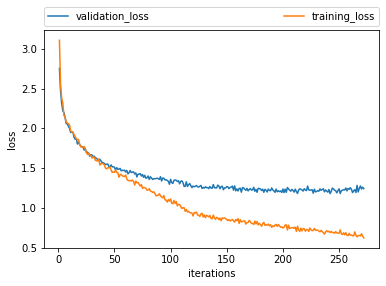

[2.7555162539848914,
 2.471749947621272,
 2.318652336414044,
 2.222760741527264,
 2.200569987297058,
 2.1432599425315857,
 2.0612626717640805,
 2.057409997169788,
 2.0264888405799866,
 2.001042466897231,
 1.9488457853977497,
 1.9521780931032622,
 1.9529064297676086,
 1.8887965725018427,
 1.8634653274829571,
 1.8734000004254854,
 1.8030516321842487,
 1.8273027401704054,
 1.7991735889361455,
 1.7778059060756977,
 1.7669476087276752,
 1.7692538087184613,
 1.7270156832841725,
 1.7411259550314684,
 1.7010887769552379,
 1.7015857238035936,
 1.6882501473793616,
 1.6496457365842967,
 1.6693137609041655,
 1.6647073580668523,
 1.6448335693432734,
 1.6495066376832814,
 1.6278023032041697,
 1.624706011552077,
 1.6074155844174898,
 1.5957415883357708,
 1.6121878027915955,
 1.5909017461996813,
 1.5698467859855065,
 1.5691262070949261,
 1.559167206287384,
 1.547184095932887,
 1.5469923340357268,
 1.5521808770986705,
 1.521672615638146,
 1.516982106062082,
 1.5404212199724638,
 1.51574713908709,
 1.51

In [67]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 0, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.175100483894348, validation_error:2.590579945465614
Best loss improvement from inf to 2.590579945465614 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.4792564606666563, validation_error:2.3755485970398476
Best loss improvement from 2.590579945465614 to 2.3755485970398476 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.290221402645111, validation_error:2.2879577505177466
Best loss improvement from 2.3755485970398476 to 2.2879577505177466 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.209105348587036, validation_error:2.2418007151833894
Best loss improvement from 2.2879577505177466 to 2.2418007151833894 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.1780920600891114, validation_error:2.141170884000844
Best loss improvement from 2.2418007151833894 to 2.141170884000844 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:2.099502692222595, validation

minibatch:127, epoch:10, iteration:2449, training_error:1.3748760867118834, validation_error:1.4569769070066254
minibatch:177, epoch:10, iteration:2499, training_error:1.3842190051078795, validation_error:1.4512248614738728
minibatch:227, epoch:10, iteration:2549, training_error:1.3534833681583405, validation_error:1.4392371753166462
minibatch:19, epoch:11, iteration:2599, training_error:1.3724885010719299, validation_error:1.4553130084070667
minibatch:69, epoch:11, iteration:2649, training_error:1.3578961491584778, validation_error:1.4110282823957245
Best loss improvement from 1.438082164731519 to 1.4110282823957245 in epoch 11
minibatch:119, epoch:11, iteration:2699, training_error:1.3280124616622926, validation_error:1.4064424695639774
Best loss improvement from 1.4110282823957245 to 1.4064424695639774 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:1.308123652935028, validation_error:1.4253222079112613
minibatch:219, epoch:11, iteration:2799, training_error:1.33

minibatch:131, epoch:22, iteration:5549, training_error:0.9843877303600311, validation_error:1.2602615541425244
minibatch:181, epoch:22, iteration:5599, training_error:0.9597181630134582, validation_error:1.2452460301333461
minibatch:231, epoch:22, iteration:5649, training_error:0.9556364107131958, validation_error:1.2493641767008552
minibatch:23, epoch:23, iteration:5699, training_error:0.9204534947872162, validation_error:1.2403010479335128
minibatch:73, epoch:23, iteration:5749, training_error:0.9377977550029755, validation_error:1.2321077790753594
Patience ran out at 5749. Finetuning, and improving patience.
minibatch:123, epoch:23, iteration:5799, training_error:0.9013234412670136, validation_error:1.2027449525635818
Best loss improvement from 1.2317830817452793 to 1.2027449525635818 in epoch 23
minibatch:173, epoch:23, iteration:5849, training_error:0.9171625888347625, validation_error:1.1983862437050918
Best loss improvement from 1.2027449525635818 to 1.1983862437050918 in epoch

minibatch:177, epoch:35, iteration:8949, training_error:0.717593520283699, validation_error:1.1847760019631222
minibatch:227, epoch:35, iteration:8999, training_error:0.7774206304550171, validation_error:1.1338727576979275
minibatch:19, epoch:36, iteration:9049, training_error:0.7642419052124023, validation_error:1.1578904349228432
minibatch:69, epoch:36, iteration:9099, training_error:0.7457682192325592, validation_error:1.1091860471100643
Best loss improvement from 1.127780166165582 to 1.1091860471100643 in epoch 36
minibatch:119, epoch:36, iteration:9149, training_error:0.8053632616996765, validation_error:1.1417978837572296
minibatch:169, epoch:36, iteration:9199, training_error:0.7322818648815155, validation_error:1.1275784085536826
minibatch:219, epoch:36, iteration:9249, training_error:0.7341864985227585, validation_error:1.1748511112969497
minibatch:11, epoch:37, iteration:9299, training_error:0.7525104254484176, validation_error:1.1343120089892684
minibatch:61, epoch:37, itera

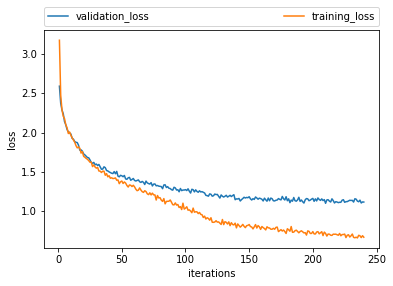

[2.590579945465614,
 2.3755485970398476,
 2.2879577505177466,
 2.2418007151833894,
 2.141170884000844,
 2.1003699220460037,
 2.039501502596099,
 2.0101479620769105,
 1.995890370730696,
 1.9822993155183464,
 1.9271681020999778,
 1.9162342918330226,
 1.8864217955490639,
 1.8768702334371106,
 1.8736089303575714,
 1.8403194156186333,
 1.7773589224650943,
 1.7808893055751407,
 1.764466380250865,
 1.7296763370777,
 1.7165293282475964,
 1.6990659154694656,
 1.6830756540956169,
 1.6800956726074219,
 1.6527374366234089,
 1.6207256152712066,
 1.6095572545610626,
 1.621299250372525,
 1.5905777257064293,
 1.6003501990745808,
 1.581487593979671,
 1.595451831817627,
 1.5654222307534054,
 1.5342315188769637,
 1.536147380697316,
 1.5652353928006928,
 1.5544913637227025,
 1.5184878727485394,
 1.512548931713762,
 1.5006905711930374,
 1.4928983326615959,
 1.4836476260218128,
 1.4791593017249272,
 1.504629291337112,
 1.476540914897261,
 1.5069848792306308,
 1.446149151900719,
 1.438082164731519,
 1.456976

In [68]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 1, 1, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 2, 1, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 3, 1, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 4, 1, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:3.046460952758789, validation_error:2.6522602484776425
Best loss improvement from inf to 2.6522602484776425 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.4875435495376585, validation_error:2.452755873019879
Best loss improvement from 2.6522602484776425 to 2.452755873019879 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.361239233016968, validation_error:2.3355410190728993
Best loss improvement from 2.452755873019879 to 2.3355410190728993 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.2841483688354494, validation_error:2.2443189437572775
Best loss improvement from 2.3355410190728993 to 2.2443189437572775 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.2043292689323426, validation_error:2.1906503484799313
Best loss improvement from 2.2443189437572775 to 2.1906503484799313 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.178052921295166, validati

minibatch:179, epoch:11, iteration:2549, training_error:1.571358106136322, validation_error:1.5512207196309016
Best loss improvement from 1.558859027349032 to 1.5512207196309016 in epoch 11
minibatch:229, epoch:11, iteration:2599, training_error:1.5532672476768494, validation_error:1.5592188284947321
minibatch:42, epoch:12, iteration:2649, training_error:1.5632428979873658, validation_error:1.5573597917189965
minibatch:92, epoch:12, iteration:2699, training_error:1.571087589263916, validation_error:1.5345491904478807
Best loss improvement from 1.5512207196309016 to 1.5345491904478807 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.5482741260528565, validation_error:1.5486365602566645
minibatch:192, epoch:12, iteration:2799, training_error:1.5386485052108765, validation_error:1.5290639446331904
Best loss improvement from 1.5345491904478807 to 1.5290639446331904 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.5223074245452881, validation_error:1.

minibatch:185, epoch:23, iteration:5399, training_error:1.280842353105545, validation_error:1.3437886329797597
minibatch:235, epoch:23, iteration:5449, training_error:1.288314688205719, validation_error:1.3345945110687842
Best loss improvement from 1.3398873851849482 to 1.3345945110687842 in epoch 23
minibatch:48, epoch:24, iteration:5499, training_error:1.277012332677841, validation_error:1.3374381982363188
minibatch:98, epoch:24, iteration:5549, training_error:1.2651775789260864, validation_error:1.3249123921761146
Best loss improvement from 1.3345945110687842 to 1.3249123921761146 in epoch 24
minibatch:148, epoch:24, iteration:5599, training_error:1.2711334598064423, validation_error:1.3341489434242249
minibatch:198, epoch:24, iteration:5649, training_error:1.2927648615837097, validation_error:1.3525032492784352
minibatch:11, epoch:25, iteration:5699, training_error:1.251052874326706, validation_error:1.3437607425909777
minibatch:61, epoch:25, iteration:5749, training_error:1.261708

minibatch:117, epoch:37, iteration:8649, training_error:1.0054270756244659, validation_error:1.2053283705161169
minibatch:167, epoch:37, iteration:8699, training_error:0.9968683433532715, validation_error:1.2112944561701555
minibatch:217, epoch:37, iteration:8749, training_error:1.0410398471355438, validation_error:1.199244567981133
Best loss improvement from 1.2025620089127467 to 1.199244567981133 in epoch 37
minibatch:30, epoch:38, iteration:8799, training_error:1.061905255317688, validation_error:1.1851827800273895
Best loss improvement from 1.199244567981133 to 1.1851827800273895 in epoch 38
minibatch:80, epoch:38, iteration:8849, training_error:1.0080165147781373, validation_error:1.244793332540072
minibatch:130, epoch:38, iteration:8899, training_error:1.029260711669922, validation_error:1.2061271415306971
minibatch:180, epoch:38, iteration:8949, training_error:1.0132884871959686, validation_error:1.2192585124419286
minibatch:230, epoch:38, iteration:8999, training_error:1.020952

minibatch:12, epoch:52, iteration:12099, training_error:0.9100832211971283, validation_error:1.1843426617292256
minibatch:62, epoch:52, iteration:12149, training_error:0.9254527795314789, validation_error:1.2077999046215644
minibatch:112, epoch:52, iteration:12199, training_error:0.9426335716247558, validation_error:1.1779523331385393
minibatch:162, epoch:52, iteration:12249, training_error:0.9327369177341461, validation_error:1.1899548906546373
minibatch:212, epoch:52, iteration:12299, training_error:0.9152688539028168, validation_error:1.2126015906150525
minibatch:25, epoch:53, iteration:12349, training_error:0.9320699465274811, validation_error:1.170160880455604
minibatch:75, epoch:53, iteration:12399, training_error:0.9514839029312134, validation_error:1.202678348009403
minibatch:125, epoch:53, iteration:12449, training_error:0.9566090619564056, validation_error:1.1591201722621918
Patience ran out at 12449. Ending training


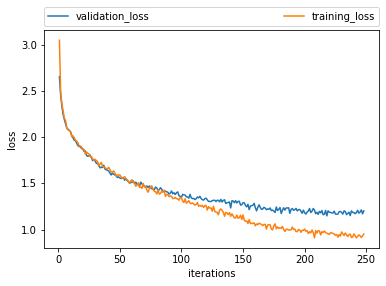

[2.6522602484776425,
 2.452755873019879,
 2.3355410190728993,
 2.2443189437572775,
 2.1906503484799313,
 2.144196840432974,
 2.0953972247930674,
 2.085804141484774,
 2.0722975685046268,
 2.0579106899408193,
 2.019588209115542,
 1.9929194083580604,
 1.9652767777442932,
 1.9627320720599248,
 1.9338324620173528,
 1.9088000792723436,
 1.8971211589299715,
 1.8972527063809907,
 1.8750658126977773,
 1.8727688651818495,
 1.843190413254958,
 1.8495581379303565,
 1.8021294382902293,
 1.791579090631925,
 1.797021677860847,
 1.8039824687517607,
 1.7763579854598412,
 1.7451747197371263,
 1.7594741949668298,
 1.741347808104295,
 1.7156753035692067,
 1.716086222575261,
 1.692625527198498,
 1.6675205551660979,
 1.674107244381538,
 1.670543216742002,
 1.6958736869005056,
 1.6542593836784363,
 1.645132670035729,
 1.642816690298227,
 1.6327038865823011,
 1.6118532831852252,
 1.5899165410261888,
 1.6110575244976924,
 1.5972659312761748,
 1.5907571132366474,
 1.586437816803272,
 1.5633172071897066,
 1.5695

In [69]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 0, 2, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.919432325363159, validation_error:2.642778750123649
Best loss improvement from inf to 2.642778750123649 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.4721846532821656, validation_error:2.3763095921483535
Best loss improvement from 2.642778750123649 to 2.3763095921483535 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.3528302621841433, validation_error:2.2955789812679948
Best loss improvement from 2.3763095921483535 to 2.2955789812679948 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.265763819217682, validation_error:2.170247567111048
Best loss improvement from 2.2955789812679948 to 2.170247567111048 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:2.149839653968811, validation_error:2.143919352827401
Best loss improvement from 2.170247567111048 to 2.143919352827401 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:2.1027717351913453, validation_e

minibatch:127, epoch:10, iteration:2449, training_error:1.4437555170059204, validation_error:1.4918707157003468
minibatch:177, epoch:10, iteration:2499, training_error:1.4534273982048034, validation_error:1.4623911709621036
Best loss improvement from 1.4792346173319324 to 1.4623911709621036 in epoch 10
minibatch:227, epoch:10, iteration:2549, training_error:1.4332322573661804, validation_error:1.4929987233260582
minibatch:19, epoch:11, iteration:2599, training_error:1.4598100471496582, validation_error:1.4530914734149802
Best loss improvement from 1.4623911709621036 to 1.4530914734149802 in epoch 11
minibatch:69, epoch:11, iteration:2649, training_error:1.4454080152511597, validation_error:1.4675079296375144
minibatch:119, epoch:11, iteration:2699, training_error:1.4248864459991455, validation_error:1.4574998904918801
minibatch:169, epoch:11, iteration:2749, training_error:1.444805669784546, validation_error:1.4536552264772613
minibatch:219, epoch:11, iteration:2799, training_error:1.3

minibatch:189, epoch:21, iteration:5349, training_error:1.213237862586975, validation_error:1.2758790994512623
minibatch:239, epoch:21, iteration:5399, training_error:1.184302532672882, validation_error:1.2856860325254242
minibatch:31, epoch:22, iteration:5449, training_error:1.1886345171928405, validation_error:1.2622087022353863
Best loss improvement from 1.2669628180306534 to 1.2622087022353863 in epoch 22
minibatch:81, epoch:22, iteration:5499, training_error:1.1841077435016631, validation_error:1.2564089997061367
Best loss improvement from 1.2622087022353863 to 1.2564089997061367 in epoch 22
minibatch:131, epoch:22, iteration:5549, training_error:1.204902104139328, validation_error:1.312033303852739
minibatch:181, epoch:22, iteration:5599, training_error:1.2100041866302491, validation_error:1.2800568095568954
minibatch:231, epoch:22, iteration:5649, training_error:1.145779767036438, validation_error:1.298945967493386
minibatch:23, epoch:23, iteration:5699, training_error:1.1838002

minibatch:135, epoch:34, iteration:8649, training_error:0.979586855173111, validation_error:1.1913495269314995
minibatch:185, epoch:34, iteration:8699, training_error:0.9994721567630768, validation_error:1.190862390501746
minibatch:235, epoch:34, iteration:8749, training_error:1.0023086857795716, validation_error:1.1727947366648708
minibatch:27, epoch:35, iteration:8799, training_error:0.97165651679039, validation_error:1.183829700124675
minibatch:77, epoch:35, iteration:8849, training_error:0.9638868284225464, validation_error:1.1841982520859817
minibatch:127, epoch:35, iteration:8899, training_error:0.9695220673084259, validation_error:1.1918668500308334
minibatch:177, epoch:35, iteration:8949, training_error:0.9654835772514343, validation_error:1.186196222387511
minibatch:227, epoch:35, iteration:8999, training_error:1.0052569270133973, validation_error:1.1525639768304496
Best loss improvement from 1.1653149580133373 to 1.1525639768304496 in epoch 35
minibatch:19, epoch:36, iteratio

minibatch:81, epoch:47, iteration:11949, training_error:0.8191214454174042, validation_error:1.0806501692739026
minibatch:131, epoch:47, iteration:11999, training_error:0.8065483045578002, validation_error:1.0982197543670391
minibatch:181, epoch:47, iteration:12049, training_error:0.8202064895629883, validation_error:1.1316263942882931
minibatch:231, epoch:47, iteration:12099, training_error:0.7988332748413086, validation_error:1.0985534314451546
minibatch:23, epoch:48, iteration:12149, training_error:0.8066406083106995, validation_error:1.096069950481941
minibatch:73, epoch:48, iteration:12199, training_error:0.7968314313888549, validation_error:1.106606818478683
minibatch:123, epoch:48, iteration:12249, training_error:0.8088633984327316, validation_error:1.1068824139134636
minibatch:173, epoch:48, iteration:12299, training_error:0.8093378591537476, validation_error:1.0912953327442039
minibatch:223, epoch:48, iteration:12349, training_error:0.7980114054679871, validation_error:1.10581

minibatch:19, epoch:61, iteration:15499, training_error:0.7322248709201813, validation_error:1.0704531546296745
minibatch:69, epoch:61, iteration:15549, training_error:0.7566674131155015, validation_error:1.0704599022865295
minibatch:119, epoch:61, iteration:15599, training_error:0.7420988297462463, validation_error:1.0779725374846623
minibatch:169, epoch:61, iteration:15649, training_error:0.753298322558403, validation_error:1.0967339708887298
minibatch:219, epoch:61, iteration:15699, training_error:0.7239880216121674, validation_error:1.0486439363709812
minibatch:11, epoch:62, iteration:15749, training_error:0.744548043012619, validation_error:1.0627798335305576
minibatch:61, epoch:62, iteration:15799, training_error:0.7410809183120728, validation_error:1.0374761675966198
Best loss improvement from 1.0448121839556201 to 1.0374761675966198 in epoch 62
minibatch:111, epoch:62, iteration:15849, training_error:0.7242088139057159, validation_error:1.0404778122901917
minibatch:161, epoch:6

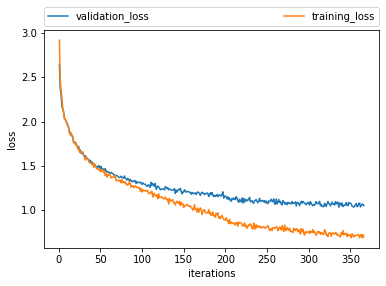

[2.642778750123649,
 2.3763095921483535,
 2.2955789812679948,
 2.170247567111048,
 2.143919352827401,
 2.1100955214993706,
 2.0447613617469527,
 2.0217840096046187,
 1.9985405042253692,
 1.9876366648180732,
 1.951706939730151,
 1.93273716137327,
 1.8869681769403919,
 1.879675030708313,
 1.8422245198282703,
 1.8428858271960555,
 1.8266134673151477,
 1.7617011645744587,
 1.7609080405070865,
 1.7637995892557605,
 1.7309322398284386,
 1.7289113669559872,
 1.7121029968919426,
 1.7176735606686822,
 1.6821963293799038,
 1.6766033748100544,
 1.6432058523441184,
 1.638369346487111,
 1.6474429081226218,
 1.621072477307813,
 1.6103410227545376,
 1.6131976226280476,
 1.5989950607562888,
 1.584894661245675,
 1.570292670151283,
 1.5707154808373287,
 1.5525921994242176,
 1.5611994924216435,
 1.5428717547449573,
 1.5426266316709847,
 1.5247244094980175,
 1.5257893759628822,
 1.5009771708784432,
 1.5067808052589153,
 1.4884275403516045,
 1.484760309087819,
 1.4792346173319324,
 1.5015074795690075,
 1.4

In [70]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 1, 2, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 2, 2, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 3, 2, patience=10)

In [ ]:
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH))
freeze_layer(model.conv1)
freeze_layer(model.pool1)
freeze_layer(model.conv2)
freeze_layer(model.pool2)
freeze_layer(model.conv3)
freeze_layer(model.pool3)
model.fc3 = nn.Linear(512, 18)

pretrain_save(model, 'age', 4, 2, patience=10)

In [71]:
print(get_performance_of_a_model("test", "gender", 0, 0))
print(get_performance_of_a_model("test", "gender", 1, 0))
print(get_performance_of_a_model("test", "gender", 2, 0))
print(get_performance_of_a_model("test", "gender", 3, 0))
print(get_performance_of_a_model("test", "gender", 4, 0))

{'accuracy': 0.7973546293985525}
{'accuracy': 0.7922185430463576}
{'accuracy': 0.7963020996552804}
{'accuracy': 0.8056057866184448}
{'accuracy': 0.790643950332082}


In [72]:
print(get_performance_of_a_model("test", "gender", 0, 1))
print(get_performance_of_a_model("test", "gender", 1, 1))
print(get_performance_of_a_model("test", "gender", 2, 1))
print(get_performance_of_a_model("test", "gender", 3, 1))
print(get_performance_of_a_model("test", "gender", 4, 1))

{'accuracy': 0.8183179435987022}
{'accuracy': 0.8082229580573952}
{'accuracy': 0.8053901598245065}
{'accuracy': 0.8339361060880048}
{'accuracy': 0.792087785157378}


In [73]:
print(get_performance_of_a_model("test", "gender", 0, 2))
print(get_performance_of_a_model("test", "gender", 1, 2))
print(get_performance_of_a_model("test", "gender", 2, 2))
print(get_performance_of_a_model("test", "gender", 3, 2))
print(get_performance_of_a_model("test", "gender", 4, 2))

{'accuracy': 0.8472672822560519}
{'accuracy': 0.8311258278145696}
{'accuracy': 0.8260733312441241}
{'accuracy': 0.8502109704641351}
{'accuracy': 0.8157666762922322}


In [74]:
print(get_performance_of_a_model("test", "both", 0, 0))
print(get_performance_of_a_model("test", "both", 1, 0))
print(get_performance_of_a_model("test", "both", 2, 0))
print(get_performance_of_a_model("test", "both", 3, 0))
print(get_performance_of_a_model("test", "both", 4, 0))

{'accuracy': 0.3645269399329724, 'one-off accuracy': 0.617169373549884, 'gender accuracy': 0.7824181490074762, 'age accuracy': 0.3720030935808198, 'one-off age accuracy': 0.6432070121165249}
{'accuracy': 0.2658901830282862, 'one-off accuracy': 0.5680532445923461, 'gender accuracy': 0.7753743760399334, 'age accuracy': 0.2762063227953411, 'one-off age accuracy': 0.605324459234609}
{'accuracy': 0.29541813521307275, 'one-off accuracy': 0.5719320730535085, 'gender accuracy': 0.7715475809035566, 'age accuracy': 0.3043896187119513, 'one-off age accuracy': 0.6074975969240628}
{'accuracy': 0.3311235170969993, 'one-off accuracy': 0.6175854849965108, 'gender accuracy': 0.7955338450802513, 'age accuracy': 0.34473133286810886, 'one-off age accuracy': 0.6566643405443127}
{'accuracy': 0.2816651904340124, 'one-off accuracy': 0.5591969294360791, 'gender accuracy': 0.7599645704162976, 'age accuracy': 0.29022733982875704, 'one-off age accuracy': 0.5937407735459108}


In [75]:
print(get_performance_of_a_model("test", "both", 0, 1))
print(get_performance_of_a_model("test", "both", 1, 1))
print(get_performance_of_a_model("test", "both", 2, 1))
print(get_performance_of_a_model("test", "both", 3, 1))
print(get_performance_of_a_model("test", "both", 4, 1))

{'accuracy': 0.4016499097705594, 'one-off accuracy': 0.6576437226089198, 'gender accuracy': 0.805620005155968, 'age accuracy': 0.4073214746068574, 'one-off age accuracy': 0.682907965970611}
{'accuracy': 0.286522462562396, 'one-off accuracy': 0.616638935108153, 'gender accuracy': 0.8086522462562395, 'age accuracy': 0.2931780366056572, 'one-off age accuracy': 0.6425956738768719}
{'accuracy': 0.3345081704581865, 'one-off accuracy': 0.6203140019224608, 'gender accuracy': 0.7952579301505928, 'age accuracy': 0.34091637295738547, 'one-off age accuracy': 0.644024351169497}
{'accuracy': 0.3440334961618981, 'one-off accuracy': 0.6454989532449407, 'gender accuracy': 0.8105373342637823, 'age accuracy': 0.3531053733426378, 'one-off age accuracy': 0.6730635031402652}
{'accuracy': 0.2973132565692353, 'one-off accuracy': 0.5869501033362858, 'gender accuracy': 0.7776793622674933, 'age accuracy': 0.30823737821080605, 'one-off age accuracy': 0.6185414821375849}


In [76]:
print(get_performance_of_a_model("test", "both", 0, 2))
print(get_performance_of_a_model("test", "both", 1, 2))
print(get_performance_of_a_model("test", "both", 2, 2))
print(get_performance_of_a_model("test", "both", 3, 2))
print(get_performance_of_a_model("test", "both", 4, 2))

{'accuracy': 0.41634441866460425, 'one-off accuracy': 0.6960556844547564, 'gender accuracy': 0.8280484660995102, 'age accuracy': 0.42046919309100284, 'one-off age accuracy': 0.711265790152101}
{'accuracy': 0.30748752079866887, 'one-off accuracy': 0.632279534109817, 'gender accuracy': 0.8143094841930116, 'age accuracy': 0.3141430948419301, 'one-off age accuracy': 0.653910149750416}
{'accuracy': 0.34476129445690484, 'one-off accuracy': 0.6395386094200577, 'gender accuracy': 0.8112784363985902, 'age accuracy': 0.3550144184556232, 'one-off age accuracy': 0.6642101890419737}
{'accuracy': 0.3674110258199581, 'one-off accuracy': 0.6699232379623168, 'gender accuracy': 0.8283321702721563, 'age accuracy': 0.3743893928820656, 'one-off age accuracy': 0.6933007676203768}
{'accuracy': 0.3256569235311485, 'one-off accuracy': 0.6371420135813404, 'gender accuracy': 0.8004133451431946, 'age accuracy': 0.33244759374077354, 'one-off age accuracy': 0.6598759964570416}


In [77]:
print(get_performance_of_a_model("test", "age", 0, 0))
print(get_performance_of_a_model("test", "age", 1, 0))
#print(get_performance_of_a_model("test", "age", 2, 0))
#print(get_performance_of_a_model("test", "age", 3, 0))
#print(get_performance_of_a_model("test", "age", 4, 0))

{'accuracy': 0.48169601482854496, 'one-off accuracy': 0.7847544022242817}
{'accuracy': 0.33731054498548857, 'one-off accuracy': 0.7197678168332796}


In [78]:
print(get_performance_of_a_model("test", "age", 0, 1))
print(get_performance_of_a_model("test", "age", 1, 1))
#print(get_performance_of_a_model("test", "age", 2, 1))
#print(get_performance_of_a_model("test", "age", 3, 1))
#print(get_performance_of_a_model("test", "age", 4, 1))

{'accuracy': 0.507645968489342, 'one-off accuracy': 0.8229842446709916}
{'accuracy': 0.3544018058690745, 'one-off accuracy': 0.7462108997097711}


In [79]:
print(get_performance_of_a_model("test", "age", 0, 2))
print(get_performance_of_a_model("test", "age", 1, 2))
#print(get_performance_of_a_model("test", "age", 2, 2))
#print(get_performance_of_a_model("test", "age", 3, 2))
#print(get_performance_of_a_model("test", "age", 4, 2))

{'accuracy': 0.5289620018535681, 'one-off accuracy': 0.8229842446709916}
{'accuracy': 0.3711705901322154, 'one-off accuracy': 0.745565946468881}
